<a href="https://colab.research.google.com/github/gi3265/-DACON-Bit_Trader/blob/main/%5BDacon%5DBit_Trader_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Library Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Flatten
import numpy as np
import pandas as pd
# import os.path
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 2. 데이터 가공

## 2.1 read_csv

In [ ]:
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]BIt_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2.2 numpy array로 변환

In [ ]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)   #(7362, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(7362, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

# 3. 모델 훈련하기

## 3.1 훈련 층 쌓기(모델 구성)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape = [1380, 1]))
model.add(Dense(240, activation = 'relu'))
model.add(Dense(120, activation = 'relu'))
model.add(Dense(120, activation = 'relu'))
model.add(Reshape([120,1]))

In [ ]:
# model=Sequential([
# LSTM(units = 32, input_shape=[1380, 1]),   #activation = 'relu'넣으니 학습 제대로 안 됐음.
# Dense(120 * 1),
# Reshape([120, 1])
# ])

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5)




In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 240)               15600     
_________________________________________________________________
dense_1 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_________________________________________________________________
reshape (Reshape)            (None, 120, 1)            0         
Total params: 75,936
Trainable params: 75,936
Non-trainable params: 0
_________________________________________________________________


## 3.2 validation set 훈련(sample_id: 0~529)

### 3.2.1 validation 데이터 생성하기

In [ ]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 529]
valid_y_df = train_y_df[train_y_df.sample_id < 529]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([len(valid_x_array), 120, 1])

### 3.2.2 학습 및 test_x 예측하고 해당 내용 test_pred_array에 기록

In [ ]:
test_pred_array = np.zeros([529, 120, 1])

for idx in tqdm(range(valid_x_array.shape[0])):
    #학습
    x_series = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
    y_series = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
    test_x_series = np.reshape(test_x_array[idx,:,1], (1, 1380,1)) #각 open 값의 3차원형

    preds = model.predict(test_x_series)
    test_pred_array[idx,:] = preds

    model.fit(x_series, y_series, epochs = 10, batch_size = 32)

    #여기서 predict를 바로 해야 함
    preds = model.predict(test_x_series)
    test_pred_array[idx,:] = preds

  0%|          | 0/529 [00:00<?, ?it/s]

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.9482 - mse: 0.9482
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.9243 - mse: 0.9243
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.8965 - mse: 0.8965
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.8632 - mse: 0.8632
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.8233 - mse: 0.8233
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.7748 - mse: 0.7748
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.7161 - mse: 0.7161
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.6489 - mse: 0.6489
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.5790 - mse: 0.5790
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.5231 - mse: 0.5231


  0%|          | 1/529 [00:33<4:55:02, 33.53s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.5153 - mse: 0.5153
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.5341 - mse: 0.5341
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.5357 - mse: 0.5357
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.5102 - mse: 0.5102
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.4733 - mse: 0.4733
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.4405 - mse: 0.4405
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.4183 - mse: 0.4183
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.4072 - mse: 0.4072
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.4023 - mse: 0.4023
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3984 - mse: 0.3984


  0%|          | 2/529 [00:34<3:28:18, 23.72s/it]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3889 - mse: 0.3889
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3817 - mse: 0.3817
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3731 - mse: 0.3731
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3631 - mse: 0.3631
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3547 - mse: 0.3547
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3491 - mse: 0.3491
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3462 - mse: 0.3462
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3442 - mse: 0.3442
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3416 - mse: 0.3416
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3374 - mse: 0.3374


  1%|          | 3/529 [00:35<2:27:40, 16.84s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3312 - mse: 0.3312
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3262 - mse: 0.3262
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3225 - mse: 0.3225
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3202 - mse: 0.3202
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3192 - mse: 0.3192
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3186 - mse: 0.3186
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3179 - mse: 0.3179
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3170 - mse: 0.3170
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3157 - mse: 0.3157
Epoch 10/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3144 - mse: 0.3144


  1%|          | 4/529 [00:35<1:45:15, 12.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3134 - mse: 0.3134
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3130 - mse: 0.3130
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3129 - mse: 0.3129
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3129 - mse: 0.3129
Epoch 5/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3128 - mse: 0.3128
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3124 - mse: 0.3124
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3118 - mse: 0.3118
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3113 - mse: 0.3113
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3110 - mse: 0.3110
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3109 - mse: 0.3109


  1%|          | 5/529 [00:36<1:15:33,  8.65s/it]

Epoch 1/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3266 - mse: 0.3266
Epoch 2/10
1/1 [==============================] - 0s 51ms/step - loss: 0.3266 - mse: 0.3266
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3262 - mse: 0.3262
Epoch 4/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3256 - mse: 0.3256
Epoch 5/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3251 - mse: 0.3251
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3249 - mse: 0.3249
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3250 - mse: 0.3250
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3252 - mse: 0.3252
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3251 - mse: 0.3251
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3249 - mse: 0.3249


  1%|          | 6/529 [00:37<54:48,  6.29s/it]  

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3117 - mse: 0.3117
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3110 - mse: 0.3110
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3105 - mse: 0.3105
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3105 - mse: 0.3105
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3107 - mse: 0.3107
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3110 - mse: 0.3110
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3110 - mse: 0.3110
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3108 - mse: 0.3108
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3105 - mse: 0.3105
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3102 - mse: 0.3102


  1%|▏         | 7/529 [00:38<40:21,  4.64s/it]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3099 - mse: 0.3099
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3100 - mse: 0.3100
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3101 - mse: 0.3101
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3101 - mse: 0.3101
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3100 - mse: 0.3100
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3099 - mse: 0.3099
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3097 - mse: 0.3097
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3097 - mse: 0.3097
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3098 - mse: 0.3098
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3098 - mse: 0.3098


  2%|▏         | 8/529 [00:39<30:13,  3.48s/it]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3067 - mse: 0.3067
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - mse: 0.3066
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3066 - mse: 0.3066
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3065 - mse: 0.3065


  2%|▏         | 9/529 [00:39<23:11,  2.68s/it]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3099 - mse: 0.3099
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3099 - mse: 0.3099
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3099 - mse: 0.3099
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3099 - mse: 0.3099
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3098 - mse: 0.3098
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3098 - mse: 0.3098
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3098 - mse: 0.3098
Epoch 8/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3098 - mse: 0.3098
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3098 - mse: 0.3098
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3098 - mse: 0.3098


  2%|▏         | 10/529 [00:40<18:14,  2.11s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3036 - mse: 0.3036
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3035 - mse: 0.3035
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3035 - mse: 0.3035
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3035 - mse: 0.3035
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3035 - mse: 0.3035
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3035 - mse: 0.3035
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3035 - mse: 0.3035
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3034 - mse: 0.3034
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3034 - mse: 0.3034
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3033 - mse: 0.3033


  2%|▏         | 11/529 [00:41<14:48,  1.71s/it]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3079 - mse: 0.3079
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3079 - mse: 0.3079
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3079 - mse: 0.3079
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3079 - mse: 0.3079


  2%|▏         | 12/529 [00:42<12:23,  1.44s/it]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3121 - mse: 0.3121
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3120 - mse: 0.3120
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3120 - mse: 0.3120
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3119 - mse: 0.3119
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3119 - mse: 0.3119
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3120 - mse: 0.3120
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3120 - mse: 0.3120
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3120 - mse: 0.3120
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3119 - mse: 0.3119
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3119 - mse: 0.3119


  2%|▏         | 13/529 [00:43<10:41,  1.24s/it]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3047 - mse: 0.3047
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3046 - mse: 0.3046
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3046 - mse: 0.3046
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3046 - mse: 0.3046
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3046 - mse: 0.3046
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3046 - mse: 0.3046
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3046 - mse: 0.3046
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3046 - mse: 0.3046
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3046 - mse: 0.3046
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3046 - mse: 0.3046


  3%|▎         | 14/529 [00:43<09:28,  1.10s/it]

Epoch 1/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3052 - mse: 0.3052
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3052 - mse: 0.3052
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.3051 - mse: 0.3051
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3051 - mse: 0.3051
Epoch 5/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3051 - mse: 0.3051
Epoch 6/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3051 - mse: 0.3051
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3051 - mse: 0.3051
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3051 - mse: 0.3051
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3051 - mse: 0.3051
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3051 - mse: 0.3051


  3%|▎         | 15/529 [00:44<08:38,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 55ms/step - loss: 0.2902 - mse: 0.2902
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.2899 - mse: 0.2899
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 0.2896 - mse: 0.2896
Epoch 4/10
1/1 [==============================] - 0s 53ms/step - loss: 0.2895 - mse: 0.2895
Epoch 5/10
1/1 [==============================] - 0s 54ms/step - loss: 0.2895 - mse: 0.2895
Epoch 6/10
1/1 [==============================] - 0s 53ms/step - loss: 0.2896 - mse: 0.2896
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2896 - mse: 0.2896
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.2894 - mse: 0.2894
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.2893 - mse: 0.2893
Epoch 10/10
1/1 [==============================] - 0s 53ms/step - loss: 0.2893 - mse: 0.2893


  3%|▎         | 16/529 [00:45<08:00,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3083 - mse: 0.3083


  3%|▎         | 17/529 [00:46<07:37,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3068 - mse: 0.3068
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3068 - mse: 0.3068
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3068 - mse: 0.3068


  3%|▎         | 18/529 [00:46<07:22,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3117 - mse: 0.3117
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3117 - mse: 0.3117
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3116 - mse: 0.3116
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3115 - mse: 0.3115
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3115 - mse: 0.3115
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3116 - mse: 0.3116
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3116 - mse: 0.3116
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3116 - mse: 0.3116
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3115 - mse: 0.3115
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3115 - mse: 0.3115


  4%|▎         | 19/529 [00:47<07:09,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3061 - mse: 0.3061
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3061 - mse: 0.3061
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3061 - mse: 0.3061
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3061 - mse: 0.3061
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3061 - mse: 0.3061
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3061 - mse: 0.3061
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3061 - mse: 0.3061
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3061 - mse: 0.3061
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3061 - mse: 0.3061
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3061 - mse: 0.3061


  4%|▍         | 20/529 [00:48<07:02,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3082 - mse: 0.3082
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3082 - mse: 0.3082
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3082 - mse: 0.3082
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3082 - mse: 0.3082
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3082 - mse: 0.3082


  4%|▍         | 21/529 [00:49<06:59,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3055 - mse: 0.3055
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3055 - mse: 0.3055
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3055 - mse: 0.3055
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3055 - mse: 0.3055
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3055 - mse: 0.3055
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3055 - mse: 0.3055
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3055 - mse: 0.3055
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3054 - mse: 0.3054
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3054 - mse: 0.3054
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3054 - mse: 0.3054


  4%|▍         | 22/529 [00:50<06:57,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3084 - mse: 0.3084


  4%|▍         | 23/529 [00:51<06:57,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3181 - mse: 0.3181
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3180 - mse: 0.3180
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3179 - mse: 0.3179
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3179 - mse: 0.3179
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3180 - mse: 0.3180
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3180 - mse: 0.3180
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3179 - mse: 0.3179
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3179 - mse: 0.3179
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3179 - mse: 0.3179
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3179 - mse: 0.3179


  5%|▍         | 24/529 [00:51<06:53,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3096 - mse: 0.3096
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3096 - mse: 0.3096
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3096 - mse: 0.3096
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3096 - mse: 0.3096
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3096 - mse: 0.3096


  5%|▍         | 25/529 [00:52<06:49,  1.23it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3105 - mse: 0.3105
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3105 - mse: 0.3105
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3105 - mse: 0.3105
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3105 - mse: 0.3105
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3104 - mse: 0.3104
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3104 - mse: 0.3104
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3104 - mse: 0.3104
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3104 - mse: 0.3104
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3104 - mse: 0.3104
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3104 - mse: 0.3104


  5%|▍         | 26/529 [00:53<06:49,  1.23it/s]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3042 - mse: 0.3042
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3041 - mse: 0.3041
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3041 - mse: 0.3041
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3041 - mse: 0.3041
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3041 - mse: 0.3041
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3041 - mse: 0.3041
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3041 - mse: 0.3041
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3041 - mse: 0.3041
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3041 - mse: 0.3041
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3041 - mse: 0.3041


  5%|▌         | 27/529 [00:54<06:44,  1.24it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3182 - mse: 0.3182
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3181 - mse: 0.3181
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3180 - mse: 0.3180
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3180 - mse: 0.3180
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3181 - mse: 0.3181
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3181 - mse: 0.3181
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3180 - mse: 0.3180
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3180 - mse: 0.3180
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3180 - mse: 0.3180
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3180 - mse: 0.3180


  5%|▌         | 28/529 [00:55<06:43,  1.24it/s]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3080 - mse: 0.3080
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3079 - mse: 0.3079
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078


  5%|▌         | 29/529 [00:55<06:42,  1.24it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3117 - mse: 0.3117
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3117 - mse: 0.3117
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3117 - mse: 0.3117
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3117 - mse: 0.3117
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3117 - mse: 0.3117
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3117 - mse: 0.3117
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3117 - mse: 0.3117
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3117 - mse: 0.3117
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3117 - mse: 0.3117
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3117 - mse: 0.3117


  6%|▌         | 30/529 [00:56<06:41,  1.24it/s]

Epoch 1/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3075 - mse: 0.3075
Epoch 5/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3075 - mse: 0.3075
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3075 - mse: 0.3075


  6%|▌         | 31/529 [00:57<06:37,  1.25it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3074 - mse: 0.3074
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3074 - mse: 0.3074


  6%|▌         | 32/529 [00:58<06:34,  1.26it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3108 - mse: 0.3108
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.3108 - mse: 0.3108
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3108 - mse: 0.3108
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3108 - mse: 0.3108
Epoch 6/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3108 - mse: 0.3108
Epoch 8/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3108 - mse: 0.3108
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3108 - mse: 0.3108


  6%|▌         | 33/529 [00:58<06:31,  1.27it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3051 - mse: 0.3051
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3051 - mse: 0.3051
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3051 - mse: 0.3051
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3051 - mse: 0.3051
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3051 - mse: 0.3051
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3051 - mse: 0.3051
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3051 - mse: 0.3051
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3051 - mse: 0.3051
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3051 - mse: 0.3051
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3051 - mse: 0.3051


  6%|▋         | 34/529 [00:59<06:30,  1.27it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3085 - mse: 0.3085


  7%|▋         | 35/529 [01:00<06:32,  1.26it/s]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3148 - mse: 0.3148
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3147 - mse: 0.3147
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3147 - mse: 0.3147
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3147 - mse: 0.3147
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3147 - mse: 0.3147
Epoch 6/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3147 - mse: 0.3147
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3147 - mse: 0.3147
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3147 - mse: 0.3147
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3147 - mse: 0.3147
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3147 - mse: 0.3147


  7%|▋         | 36/529 [01:01<06:32,  1.26it/s]

Epoch 1/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3072 - mse: 0.3072
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3072 - mse: 0.3072
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3072 - mse: 0.3072
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3072 - mse: 0.3072
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3072 - mse: 0.3072
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3072 - mse: 0.3072


  7%|▋         | 37/529 [01:02<06:30,  1.26it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3195 - mse: 0.3195
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3194 - mse: 0.3194
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3193 - mse: 0.3193
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3193 - mse: 0.3193
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3193 - mse: 0.3193
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3193 - mse: 0.3193
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3192 - mse: 0.3192
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3192 - mse: 0.3192
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3193 - mse: 0.3193
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3192 - mse: 0.3192


  7%|▋         | 38/529 [01:02<06:34,  1.24it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084


  7%|▋         | 39/529 [01:03<06:35,  1.24it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3080 - mse: 0.3080
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3080 - mse: 0.3080
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3080 - mse: 0.3080
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3080 - mse: 0.3080
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3080 - mse: 0.3080
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3080 - mse: 0.3080
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3080 - mse: 0.3080
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3080 - mse: 0.3080


  8%|▊         | 40/529 [01:04<06:37,  1.23it/s]

Epoch 1/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3116 - mse: 0.3116
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3116 - mse: 0.3116
Epoch 3/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3116 - mse: 0.3116
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3115 - mse: 0.3115
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3115 - mse: 0.3115
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3115 - mse: 0.3115
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3115 - mse: 0.3115
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3115 - mse: 0.3115
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3115 - mse: 0.3115
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3115 - mse: 0.3115


  8%|▊         | 41/529 [01:05<06:36,  1.23it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3090 - mse: 0.3090
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3089 - mse: 0.3089
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3089 - mse: 0.3089
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3089 - mse: 0.3089
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3089 - mse: 0.3089
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3089 - mse: 0.3089
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3089 - mse: 0.3089


  8%|▊         | 42/529 [01:06<06:38,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3105 - mse: 0.3105
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3105 - mse: 0.3105
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3105 - mse: 0.3105
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3105 - mse: 0.3105
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3105 - mse: 0.3105
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3105 - mse: 0.3105
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3105 - mse: 0.3105
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3105 - mse: 0.3105
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3105 - mse: 0.3105
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3105 - mse: 0.3105


  8%|▊         | 43/529 [01:07<06:37,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3088 - mse: 0.3088
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3088 - mse: 0.3088
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3088 - mse: 0.3088


  8%|▊         | 44/529 [01:07<06:36,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3087 - mse: 0.3087


  9%|▊         | 45/529 [01:08<06:35,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2929 - mse: 0.2929
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.2925 - mse: 0.2925
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2923 - mse: 0.2923
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2924 - mse: 0.2924
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2925 - mse: 0.2925
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2923 - mse: 0.2923
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2922 - mse: 0.2922
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2923 - mse: 0.2923
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2924 - mse: 0.2924
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.2923 - mse: 0.2923


  9%|▊         | 46/529 [01:09<06:36,  1.22it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3115 - mse: 0.3115
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3113 - mse: 0.3113
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3110 - mse: 0.3110
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3109 - mse: 0.3109
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3110 - mse: 0.3110
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3110 - mse: 0.3110
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3108 - mse: 0.3108
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3107 - mse: 0.3107
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3108 - mse: 0.3108


  9%|▉         | 47/529 [01:10<06:37,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3107 - mse: 0.3107
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3106 - mse: 0.3106
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3107 - mse: 0.3107
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3107 - mse: 0.3107
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3106 - mse: 0.3106
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3106 - mse: 0.3106
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3106 - mse: 0.3106
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3106 - mse: 0.3106
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3106 - mse: 0.3106
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3106 - mse: 0.3106


  9%|▉         | 48/529 [01:11<06:38,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3075 - mse: 0.3075


  9%|▉         | 49/529 [01:12<06:56,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084


  9%|▉         | 50/529 [01:13<06:49,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3025 - mse: 0.3025
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3024 - mse: 0.3024
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3024 - mse: 0.3024
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3024 - mse: 0.3024
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3024 - mse: 0.3024
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3023 - mse: 0.3023
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3023 - mse: 0.3023
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3023 - mse: 0.3023
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3024 - mse: 0.3024
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3023 - mse: 0.3023


 10%|▉         | 51/529 [01:13<06:46,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3083 - mse: 0.3083
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - mse: 0.3081


 10%|▉         | 52/529 [01:14<06:45,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3067 - mse: 0.3067
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3067 - mse: 0.3067
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3067 - mse: 0.3067
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3067 - mse: 0.3067
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3067 - mse: 0.3067
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3067 - mse: 0.3067
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3067 - mse: 0.3067
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3067 - mse: 0.3067
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3067 - mse: 0.3067
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3067 - mse: 0.3067


 10%|█         | 53/529 [01:15<06:40,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3045 - mse: 0.3045
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3045 - mse: 0.3045
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3045 - mse: 0.3045
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3044 - mse: 0.3044
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3044 - mse: 0.3044
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3044 - mse: 0.3044
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3044 - mse: 0.3044
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3044 - mse: 0.3044
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3044 - mse: 0.3044
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3044 - mse: 0.3044


 10%|█         | 54/529 [01:16<06:39,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3137 - mse: 0.3137
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3136 - mse: 0.3136
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3136 - mse: 0.3136
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3136 - mse: 0.3136
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3136 - mse: 0.3136
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3135 - mse: 0.3135
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3135 - mse: 0.3135
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3135 - mse: 0.3135
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3136 - mse: 0.3136
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3135 - mse: 0.3135


 10%|█         | 55/529 [01:17<06:38,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3056 - mse: 0.3056
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3055 - mse: 0.3055
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3054 - mse: 0.3054
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3054 - mse: 0.3054
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3055 - mse: 0.3055
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3054 - mse: 0.3054
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3054 - mse: 0.3054
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3054 - mse: 0.3054
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3054 - mse: 0.3054
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3054 - mse: 0.3054


 11%|█         | 56/529 [01:18<06:37,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3073 - mse: 0.3073


 11%|█         | 57/529 [01:18<06:34,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3036 - mse: 0.3036
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3036 - mse: 0.3036
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3036 - mse: 0.3036
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3035 - mse: 0.3035
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3035 - mse: 0.3035
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3035 - mse: 0.3035
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3035 - mse: 0.3035
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3035 - mse: 0.3035
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3035 - mse: 0.3035
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3035 - mse: 0.3035


 11%|█         | 58/529 [01:19<06:32,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3059 - mse: 0.3059
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3059 - mse: 0.3059
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3059 - mse: 0.3059
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3059 - mse: 0.3059
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3059 - mse: 0.3059
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3059 - mse: 0.3059
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3059 - mse: 0.3059
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3059 - mse: 0.3059
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3059 - mse: 0.3059
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3059 - mse: 0.3059


 11%|█         | 59/529 [01:20<06:29,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3078 - mse: 0.3078


 11%|█▏        | 60/529 [01:21<06:29,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3101 - mse: 0.3101
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3101 - mse: 0.3101
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3101 - mse: 0.3101
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3100 - mse: 0.3100
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3100 - mse: 0.3100
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3100 - mse: 0.3100
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3100 - mse: 0.3100
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3100 - mse: 0.3100
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3100 - mse: 0.3100
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3100 - mse: 0.3100


 12%|█▏        | 61/529 [01:22<06:29,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3113 - mse: 0.3113
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3113 - mse: 0.3113
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3113 - mse: 0.3113
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3113 - mse: 0.3113
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3113 - mse: 0.3113
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3113 - mse: 0.3113
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3113 - mse: 0.3113
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3113 - mse: 0.3113
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3113 - mse: 0.3113
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3113 - mse: 0.3113


 12%|█▏        | 62/529 [01:23<06:27,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3082 - mse: 0.3082
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3082 - mse: 0.3082
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3082 - mse: 0.3082
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3082 - mse: 0.3082
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3082 - mse: 0.3082


 12%|█▏        | 63/529 [01:23<06:27,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3037 - mse: 0.3037
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3037 - mse: 0.3037
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3037 - mse: 0.3037
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3037 - mse: 0.3037
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3037 - mse: 0.3037
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3037 - mse: 0.3037
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3037 - mse: 0.3037
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3037 - mse: 0.3037
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3037 - mse: 0.3037
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3037 - mse: 0.3037


 12%|█▏        | 64/529 [01:24<06:26,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3076 - mse: 0.3076
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3076 - mse: 0.3076
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3076 - mse: 0.3076
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3076 - mse: 0.3076
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3076 - mse: 0.3076


 12%|█▏        | 65/529 [01:25<06:25,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3094 - mse: 0.3094
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3094 - mse: 0.3094
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3094 - mse: 0.3094
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3094 - mse: 0.3094


 12%|█▏        | 66/529 [01:26<06:25,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3146 - mse: 0.3146
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3146 - mse: 0.3146
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3145 - mse: 0.3145
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3145 - mse: 0.3145
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3145 - mse: 0.3145
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3145 - mse: 0.3145
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3145 - mse: 0.3145
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3145 - mse: 0.3145
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3145 - mse: 0.3145
Epoch 10/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3145 - mse: 0.3145


 13%|█▎        | 67/529 [01:27<06:21,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3068 - mse: 0.3068
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3068 - mse: 0.3068
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3068 - mse: 0.3068
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3068 - mse: 0.3068
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3068 - mse: 0.3068
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3068 - mse: 0.3068
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3068 - mse: 0.3068
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3068 - mse: 0.3068


 13%|█▎        | 68/529 [01:27<06:21,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3104 - mse: 0.3104
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3104 - mse: 0.3104
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3103 - mse: 0.3103
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3103 - mse: 0.3103
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3103 - mse: 0.3103
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3103 - mse: 0.3103
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3103 - mse: 0.3103
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3103 - mse: 0.3103
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3103 - mse: 0.3103
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3103 - mse: 0.3103


 13%|█▎        | 69/529 [01:28<06:21,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3066 - mse: 0.3066
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3066 - mse: 0.3066
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3066 - mse: 0.3066


 13%|█▎        | 70/529 [01:29<06:21,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078


 13%|█▎        | 71/529 [01:30<06:18,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3089 - mse: 0.3089
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3089 - mse: 0.3089
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3089 - mse: 0.3089
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3089 - mse: 0.3089
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3089 - mse: 0.3089
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3089 - mse: 0.3089
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3089 - mse: 0.3089
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3089 - mse: 0.3089


 14%|█▎        | 72/529 [01:31<06:17,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3035 - mse: 0.3035
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3035 - mse: 0.3035
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3035 - mse: 0.3035
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3035 - mse: 0.3035
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3035 - mse: 0.3035
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3035 - mse: 0.3035
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3035 - mse: 0.3035
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3035 - mse: 0.3035
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3035 - mse: 0.3035
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3035 - mse: 0.3035


 14%|█▍        | 73/529 [01:32<06:16,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3032 - mse: 0.3032
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3032 - mse: 0.3032
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3031 - mse: 0.3031
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3031 - mse: 0.3031
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3031 - mse: 0.3031
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3031 - mse: 0.3031
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3031 - mse: 0.3031
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3031 - mse: 0.3031
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3031 - mse: 0.3031
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3031 - mse: 0.3031


 14%|█▍        | 74/529 [01:32<06:16,  1.21it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3068 - mse: 0.3068
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3068 - mse: 0.3068
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3068 - mse: 0.3068
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3068 - mse: 0.3068
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3068 - mse: 0.3068
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3068 - mse: 0.3068
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3068 - mse: 0.3068
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3068 - mse: 0.3068
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3068 - mse: 0.3068


 14%|█▍        | 75/529 [01:33<06:17,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3064 - mse: 0.3064
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3064 - mse: 0.3064
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3064 - mse: 0.3064
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064


 14%|█▍        | 76/529 [01:34<06:22,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3123 - mse: 0.3123
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3122 - mse: 0.3122
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3122 - mse: 0.3122
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3122 - mse: 0.3122
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3122 - mse: 0.3122
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3122 - mse: 0.3122
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3122 - mse: 0.3122
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3122 - mse: 0.3122
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3122 - mse: 0.3122
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3122 - mse: 0.3122


 15%|█▍        | 77/529 [01:35<06:20,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3093 - mse: 0.3093
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3093 - mse: 0.3093
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3093 - mse: 0.3093
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3093 - mse: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3092 - mse: 0.3092


 15%|█▍        | 78/529 [01:36<06:19,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3040 - mse: 0.3040
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3040 - mse: 0.3040
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3040 - mse: 0.3040
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3040 - mse: 0.3040
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3040 - mse: 0.3040
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3040 - mse: 0.3040
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3040 - mse: 0.3040
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3040 - mse: 0.3040
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3040 - mse: 0.3040
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3040 - mse: 0.3040


 15%|█▍        | 79/529 [01:37<06:17,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3127 - mse: 0.3127
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3125 - mse: 0.3125
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3125 - mse: 0.3125
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3126 - mse: 0.3126
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3125 - mse: 0.3125
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3124 - mse: 0.3124
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3125 - mse: 0.3125
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3125 - mse: 0.3125
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3124 - mse: 0.3124
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3124 - mse: 0.3124


 15%|█▌        | 80/529 [01:38<06:17,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3067 - mse: 0.3067
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3067 - mse: 0.3067
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3067 - mse: 0.3067
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - mse: 0.3066
Epoch 8/10
1/1 [==============================] - 0s 53ms/step - loss: 0.3067 - mse: 0.3067
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3066 - mse: 0.3066
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3066 - mse: 0.3066


 15%|█▌        | 81/529 [01:38<06:13,  1.20it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3080 - mse: 0.3080
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3079 - mse: 0.3079
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3079 - mse: 0.3079
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3079 - mse: 0.3079
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3079 - mse: 0.3079


 16%|█▌        | 82/529 [01:39<06:14,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3092 - mse: 0.3092


 16%|█▌        | 83/529 [01:40<06:14,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085


 16%|█▌        | 84/529 [01:41<06:14,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3093 - mse: 0.3093
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3093 - mse: 0.3093
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3093 - mse: 0.3093
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3093 - mse: 0.3093


 16%|█▌        | 85/529 [01:42<06:13,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3058 - mse: 0.3058
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3057 - mse: 0.3057
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3057 - mse: 0.3057
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3058 - mse: 0.3058
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3057 - mse: 0.3057
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3057 - mse: 0.3057
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3057 - mse: 0.3057
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3057 - mse: 0.3057
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3057 - mse: 0.3057
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3057 - mse: 0.3057


 16%|█▋        | 86/529 [01:43<06:15,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3096 - mse: 0.3096
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3096 - mse: 0.3096
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3096 - mse: 0.3096
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3095 - mse: 0.3095


 16%|█▋        | 87/529 [01:43<06:12,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3090 - mse: 0.3090
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3090 - mse: 0.3090
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3090 - mse: 0.3090
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3090 - mse: 0.3090
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3090 - mse: 0.3090
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3090 - mse: 0.3090
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.3090 - mse: 0.3090
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3090 - mse: 0.3090


 17%|█▋        | 88/529 [01:44<06:10,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3134 - mse: 0.3134
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3133 - mse: 0.3133
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3133 - mse: 0.3133
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3134 - mse: 0.3134
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3133 - mse: 0.3133
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3133 - mse: 0.3133
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3133 - mse: 0.3133
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3133 - mse: 0.3133
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3133 - mse: 0.3133
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3133 - mse: 0.3133


 17%|█▋        | 89/529 [01:45<06:08,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3097 - mse: 0.3097
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3096 - mse: 0.3096
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3096 - mse: 0.3096
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095


 17%|█▋        | 90/529 [01:46<06:09,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3112 - mse: 0.3112
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3111 - mse: 0.3111
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3110 - mse: 0.3110
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3110 - mse: 0.3110
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3110 - mse: 0.3110
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3110 - mse: 0.3110
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3110 - mse: 0.3110
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3110 - mse: 0.3110
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3110 - mse: 0.3110
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3110 - mse: 0.3110


 17%|█▋        | 91/529 [01:47<06:08,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3085 - mse: 0.3085


 17%|█▋        | 92/529 [01:48<06:08,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3103 - mse: 0.3103
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3102 - mse: 0.3102
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3102 - mse: 0.3102
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3102 - mse: 0.3102
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3102 - mse: 0.3102
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3102 - mse: 0.3102
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3102 - mse: 0.3102
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3102 - mse: 0.3102
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3102 - mse: 0.3102
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3102 - mse: 0.3102


 18%|█▊        | 93/529 [01:48<06:08,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3064 - mse: 0.3064
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3063 - mse: 0.3063
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3063 - mse: 0.3063
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3063 - mse: 0.3063
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3063 - mse: 0.3063
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3063 - mse: 0.3063
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3063 - mse: 0.3063
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3063 - mse: 0.3063
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3063 - mse: 0.3063


 18%|█▊        | 94/529 [01:49<06:06,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3086 - mse: 0.3086


 18%|█▊        | 95/529 [01:50<06:08,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3080 - mse: 0.3080
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3080 - mse: 0.3080
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3080 - mse: 0.3080
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3080 - mse: 0.3080
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3080 - mse: 0.3080
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3080 - mse: 0.3080
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3080 - mse: 0.3080
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3080 - mse: 0.3080


 18%|█▊        | 96/529 [01:51<06:07,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3043 - mse: 0.3043
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3042 - mse: 0.3042
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3042 - mse: 0.3042
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3042 - mse: 0.3042
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3042 - mse: 0.3042
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3042 - mse: 0.3042
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3042 - mse: 0.3042
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3042 - mse: 0.3042
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3042 - mse: 0.3042
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3042 - mse: 0.3042


 18%|█▊        | 97/529 [01:52<06:05,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078


 19%|█▊        | 98/529 [01:53<06:04,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3089 - mse: 0.3089
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3090 - mse: 0.3090
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3090 - mse: 0.3090
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3089 - mse: 0.3089
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3090 - mse: 0.3090
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3089 - mse: 0.3089
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3089 - mse: 0.3089


 19%|█▊        | 99/529 [01:54<06:03,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3071 - mse: 0.3071
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3071 - mse: 0.3071
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3071 - mse: 0.3071
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3071 - mse: 0.3071
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3071 - mse: 0.3071
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3071 - mse: 0.3071
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3071 - mse: 0.3071
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3071 - mse: 0.3071
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3071 - mse: 0.3071


 19%|█▉        | 100/529 [01:54<06:03,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078


 19%|█▉        | 101/529 [01:55<06:01,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3065 - mse: 0.3065
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3065 - mse: 0.3065
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3065 - mse: 0.3065
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3065 - mse: 0.3065
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3065 - mse: 0.3065
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3065 - mse: 0.3065
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3065 - mse: 0.3065
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3065 - mse: 0.3065


 19%|█▉        | 102/529 [01:56<05:59,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2922 - mse: 0.2922
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.2919 - mse: 0.2919
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.2920 - mse: 0.2920
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2920 - mse: 0.2920
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2918 - mse: 0.2918
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2918 - mse: 0.2918
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.2920 - mse: 0.2920
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2919 - mse: 0.2919
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.2918 - mse: 0.2918
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2919 - mse: 0.2919


 19%|█▉        | 103/529 [01:57<05:58,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3100 - mse: 0.3100
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3090 - mse: 0.3090
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3097 - mse: 0.3097
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3090 - mse: 0.3090
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3093 - mse: 0.3093


 20%|█▉        | 104/529 [01:58<05:58,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2990 - mse: 0.2990
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2980 - mse: 0.2980
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.2986 - mse: 0.2986
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2989 - mse: 0.2989
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2981 - mse: 0.2981
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2981 - mse: 0.2981
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2986 - mse: 0.2986
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2983 - mse: 0.2983
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.2980 - mse: 0.2980
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2984 - mse: 0.2984


 20%|█▉        | 105/529 [01:59<05:57,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3068 - mse: 0.3068
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3076 - mse: 0.3076
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3071 - mse: 0.3071


 20%|██        | 106/529 [01:59<05:56,  1.19it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3146 - mse: 0.3146
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3145 - mse: 0.3145
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3145 - mse: 0.3145
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3146 - mse: 0.3146
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3145 - mse: 0.3145
Epoch 6/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3145 - mse: 0.3145
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3145 - mse: 0.3145
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3145 - mse: 0.3145
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3145 - mse: 0.3145
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3145 - mse: 0.3145


 20%|██        | 107/529 [02:00<05:56,  1.18it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069


 20%|██        | 108/529 [02:01<05:58,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3056 - mse: 0.3056
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3056 - mse: 0.3056
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3056 - mse: 0.3056
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3056 - mse: 0.3056
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3056 - mse: 0.3056
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3056 - mse: 0.3056
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3056 - mse: 0.3056
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3056 - mse: 0.3056
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3056 - mse: 0.3056
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3056 - mse: 0.3056


 21%|██        | 109/529 [02:02<06:00,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3106 - mse: 0.3106
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3106 - mse: 0.3106
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3106 - mse: 0.3106
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3106 - mse: 0.3106
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3106 - mse: 0.3106
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3106 - mse: 0.3106
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3106 - mse: 0.3106
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3106 - mse: 0.3106
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3106 - mse: 0.3106
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3106 - mse: 0.3106


 21%|██        | 110/529 [02:03<06:03,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3093 - mse: 0.3093
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3092 - mse: 0.3092


 21%|██        | 111/529 [02:04<06:01,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3091 - mse: 0.3091


 21%|██        | 112/529 [02:05<06:02,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3083 - mse: 0.3083
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084


 21%|██▏       | 113/529 [02:06<06:00,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3091 - mse: 0.3091


 22%|██▏       | 114/529 [02:06<05:59,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3066 - mse: 0.3066
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3065 - mse: 0.3065
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3066 - mse: 0.3066


 22%|██▏       | 115/529 [02:07<06:00,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3057 - mse: 0.3057
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3056 - mse: 0.3056
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3057 - mse: 0.3057
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3056 - mse: 0.3056
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3056 - mse: 0.3056
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3056 - mse: 0.3056
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3056 - mse: 0.3056
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3056 - mse: 0.3056
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3056 - mse: 0.3056
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3056 - mse: 0.3056


 22%|██▏       | 116/529 [02:08<06:01,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3096 - mse: 0.3096
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3096 - mse: 0.3096
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3096 - mse: 0.3096
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3096 - mse: 0.3096
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3096 - mse: 0.3096
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3096 - mse: 0.3096


 22%|██▏       | 117/529 [02:09<05:59,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3072 - mse: 0.3072
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3071 - mse: 0.3071
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3072 - mse: 0.3072
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3071 - mse: 0.3071
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3071 - mse: 0.3071
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3071 - mse: 0.3071
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3071 - mse: 0.3071


 22%|██▏       | 118/529 [02:10<05:58,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3300 - mse: 0.3300
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3291 - mse: 0.3291
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3296 - mse: 0.3296
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3297 - mse: 0.3297
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3290 - mse: 0.3290
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3294 - mse: 0.3294
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3296 - mse: 0.3296
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3291 - mse: 0.3291
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3292 - mse: 0.3292
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3294 - mse: 0.3294


 22%|██▏       | 119/529 [02:11<05:57,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3127 - mse: 0.3127
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3117 - mse: 0.3117
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3128 - mse: 0.3128
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3126 - mse: 0.3126
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3115 - mse: 0.3115
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3121 - mse: 0.3121
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3124 - mse: 0.3124
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3116 - mse: 0.3116
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3118 - mse: 0.3118
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3122 - mse: 0.3122


 23%|██▎       | 120/529 [02:12<05:56,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3025 - mse: 0.3025
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3026 - mse: 0.3026
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3027 - mse: 0.3027
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3025 - mse: 0.3025
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3025 - mse: 0.3025
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3026 - mse: 0.3026
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3025 - mse: 0.3025
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3024 - mse: 0.3024
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3025 - mse: 0.3025
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3025 - mse: 0.3025


 23%|██▎       | 121/529 [02:12<05:55,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3098 - mse: 0.3098
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3098 - mse: 0.3098
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3097 - mse: 0.3097
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3098 - mse: 0.3098
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3098 - mse: 0.3098
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3097 - mse: 0.3097
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3097 - mse: 0.3097
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3098 - mse: 0.3098
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3097 - mse: 0.3097
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3097 - mse: 0.3097


 23%|██▎       | 122/529 [02:13<05:53,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3048 - mse: 0.3048
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3046 - mse: 0.3046
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3046 - mse: 0.3046
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3046 - mse: 0.3046
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3046 - mse: 0.3046
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3045 - mse: 0.3045
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3046 - mse: 0.3046
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3046 - mse: 0.3046
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3045 - mse: 0.3045
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3046 - mse: 0.3046


 23%|██▎       | 123/529 [02:14<05:50,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3065 - mse: 0.3065
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3065 - mse: 0.3065
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3065 - mse: 0.3065
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3065 - mse: 0.3065
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3065 - mse: 0.3065
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3065 - mse: 0.3065
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3065 - mse: 0.3065
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3065 - mse: 0.3065


 23%|██▎       | 124/529 [02:15<05:48,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3108 - mse: 0.3108
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3108 - mse: 0.3108
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3108 - mse: 0.3108
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3108 - mse: 0.3108
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3108 - mse: 0.3108
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3108 - mse: 0.3108
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3108 - mse: 0.3108


 24%|██▎       | 125/529 [02:16<05:46,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3121 - mse: 0.3121
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3120 - mse: 0.3120
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3120 - mse: 0.3120
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3120 - mse: 0.3120
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3120 - mse: 0.3120
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3120 - mse: 0.3120
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3120 - mse: 0.3120
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3120 - mse: 0.3120
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3120 - mse: 0.3120
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3120 - mse: 0.3120


 24%|██▍       | 126/529 [02:17<05:44,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3052 - mse: 0.3052
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3051 - mse: 0.3051
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3051 - mse: 0.3051
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3051 - mse: 0.3051
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3051 - mse: 0.3051
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3051 - mse: 0.3051
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3051 - mse: 0.3051
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3051 - mse: 0.3051
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3051 - mse: 0.3051
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3051 - mse: 0.3051


 24%|██▍       | 127/529 [02:18<05:43,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3101 - mse: 0.3101
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3100 - mse: 0.3100
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3100 - mse: 0.3100
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3100 - mse: 0.3100
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3099 - mse: 0.3099
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3100 - mse: 0.3100
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3100 - mse: 0.3100
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3099 - mse: 0.3099
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3099 - mse: 0.3099
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3100 - mse: 0.3100


 24%|██▍       | 128/529 [02:18<05:43,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091


 24%|██▍       | 129/529 [02:19<05:42,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3064 - mse: 0.3064
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3064 - mse: 0.3064
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3064 - mse: 0.3064
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3064 - mse: 0.3064


 25%|██▍       | 130/529 [02:20<05:40,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3048 - mse: 0.3048
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3048 - mse: 0.3048
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3048 - mse: 0.3048
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3048 - mse: 0.3048
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3048 - mse: 0.3048
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3048 - mse: 0.3048
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3048 - mse: 0.3048
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3048 - mse: 0.3048
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3048 - mse: 0.3048
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3048 - mse: 0.3048


 25%|██▍       | 131/529 [02:21<05:39,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3091 - mse: 0.3091


 25%|██▍       | 132/529 [02:22<05:41,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3078 - mse: 0.3078


 25%|██▌       | 133/529 [02:23<05:41,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3060 - mse: 0.3060
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3060 - mse: 0.3060
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3060 - mse: 0.3060
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3060 - mse: 0.3060
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3060 - mse: 0.3060
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3060 - mse: 0.3060
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3060 - mse: 0.3060
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3060 - mse: 0.3060
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3060 - mse: 0.3060
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3060 - mse: 0.3060


 25%|██▌       | 134/529 [02:24<05:40,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3139 - mse: 0.3139
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3137 - mse: 0.3137
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3138 - mse: 0.3138
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3138 - mse: 0.3138
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3137 - mse: 0.3137
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3137 - mse: 0.3137
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3138 - mse: 0.3138
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3137 - mse: 0.3137
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3137 - mse: 0.3137
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3138 - mse: 0.3138


 26%|██▌       | 135/529 [02:24<05:38,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3098 - mse: 0.3098
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3097 - mse: 0.3097
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3098 - mse: 0.3098
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3098 - mse: 0.3098
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3097 - mse: 0.3097
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3098 - mse: 0.3098
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3098 - mse: 0.3098
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3097 - mse: 0.3097
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3098 - mse: 0.3098
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3098 - mse: 0.3098


 26%|██▌       | 136/529 [02:25<05:35,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3075 - mse: 0.3075
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3075 - mse: 0.3075
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3075 - mse: 0.3075


 26%|██▌       | 137/529 [02:26<05:35,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3102 - mse: 0.3102
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3102 - mse: 0.3102
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3102 - mse: 0.3102
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3102 - mse: 0.3102
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3102 - mse: 0.3102
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3102 - mse: 0.3102
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3102 - mse: 0.3102
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3102 - mse: 0.3102
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3102 - mse: 0.3102
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3102 - mse: 0.3102


 26%|██▌       | 138/529 [02:27<05:35,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3093 - mse: 0.3093
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3093 - mse: 0.3093
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3093 - mse: 0.3093
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3093 - mse: 0.3093
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3093 - mse: 0.3093
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3093 - mse: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3093 - mse: 0.3093


 26%|██▋       | 139/529 [02:28<05:34,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3046 - mse: 0.3046
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3046 - mse: 0.3046
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3045 - mse: 0.3045
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3045 - mse: 0.3045
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3045 - mse: 0.3045
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3045 - mse: 0.3045
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3045 - mse: 0.3045
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3045 - mse: 0.3045
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3045 - mse: 0.3045
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3045 - mse: 0.3045


 26%|██▋       | 140/529 [02:29<05:33,  1.17it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3110 - mse: 0.3110
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3109 - mse: 0.3109
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3109 - mse: 0.3109
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3109 - mse: 0.3109
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3108 - mse: 0.3108
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3109 - mse: 0.3109
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3108 - mse: 0.3108
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3109 - mse: 0.3109


 27%|██▋       | 141/529 [02:30<05:34,  1.16it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3083 - mse: 0.3083
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3083 - mse: 0.3083
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3082 - mse: 0.3082
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3083 - mse: 0.3083
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3083 - mse: 0.3083


 27%|██▋       | 142/529 [02:31<05:36,  1.15it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3115 - mse: 0.3115
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3115 - mse: 0.3115
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3114 - mse: 0.3114
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3114 - mse: 0.3114
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3114 - mse: 0.3114
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3114 - mse: 0.3114
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3114 - mse: 0.3114
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3114 - mse: 0.3114
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3114 - mse: 0.3114
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3114 - mse: 0.3114


 27%|██▋       | 143/529 [02:31<05:39,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3192 - mse: 0.3192
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3191 - mse: 0.3191
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3191 - mse: 0.3191
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3192 - mse: 0.3192
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3191 - mse: 0.3191
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3191 - mse: 0.3191
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3191 - mse: 0.3191
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3190 - mse: 0.3190
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3190 - mse: 0.3190
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3191 - mse: 0.3191


 27%|██▋       | 144/529 [02:32<05:40,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3090 - mse: 0.3090
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3088 - mse: 0.3088


 27%|██▋       | 145/529 [02:33<05:37,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3156 - mse: 0.3156
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3154 - mse: 0.3154
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3156 - mse: 0.3156
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3152 - mse: 0.3152
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3152 - mse: 0.3152
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3155 - mse: 0.3155
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3153 - mse: 0.3153
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3152 - mse: 0.3152
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3154 - mse: 0.3154
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3152 - mse: 0.3152


 28%|██▊       | 146/529 [02:34<05:40,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3180 - mse: 0.3180
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3181 - mse: 0.3181
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3180 - mse: 0.3180
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3180 - mse: 0.3180
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3181 - mse: 0.3181
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3180 - mse: 0.3180
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3180 - mse: 0.3180
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3180 - mse: 0.3180
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3179 - mse: 0.3179
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3179 - mse: 0.3179


 28%|██▊       | 147/529 [02:35<05:42,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3060 - mse: 0.3060
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3054 - mse: 0.3054
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3056 - mse: 0.3056
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3058 - mse: 0.3058
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3054 - mse: 0.3054
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3055 - mse: 0.3055
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3057 - mse: 0.3057
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3054 - mse: 0.3054
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3054 - mse: 0.3054
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3056 - mse: 0.3056


 28%|██▊       | 148/529 [02:36<05:39,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3150 - mse: 0.3150
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3146 - mse: 0.3146
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3151 - mse: 0.3151
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3148 - mse: 0.3148
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3145 - mse: 0.3145
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3149 - mse: 0.3149
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3148 - mse: 0.3148
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3145 - mse: 0.3145
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3148 - mse: 0.3148
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3147 - mse: 0.3147


 28%|██▊       | 149/529 [02:37<05:39,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3076 - mse: 0.3076
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3074 - mse: 0.3074


 28%|██▊       | 150/529 [02:38<05:41,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3128 - mse: 0.3128
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3129 - mse: 0.3129
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3130 - mse: 0.3130
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3127 - mse: 0.3127
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3128 - mse: 0.3128
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3129 - mse: 0.3129
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3128 - mse: 0.3128
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3128 - mse: 0.3128
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3129 - mse: 0.3129
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3127 - mse: 0.3127


 29%|██▊       | 151/529 [02:39<05:38,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3003 - mse: 0.3003
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3003 - mse: 0.3003
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3004 - mse: 0.3004
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3002 - mse: 0.3002
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3002 - mse: 0.3002
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3003 - mse: 0.3003
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3002 - mse: 0.3002
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3002 - mse: 0.3002
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3003 - mse: 0.3003
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3002 - mse: 0.3002


 29%|██▊       | 152/529 [02:39<05:36,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3079 - mse: 0.3079
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3078 - mse: 0.3078


 29%|██▉       | 153/529 [02:40<05:35,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3202 - mse: 0.3202
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3200 - mse: 0.3200
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3199 - mse: 0.3199
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3201 - mse: 0.3201
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3199 - mse: 0.3199
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3199 - mse: 0.3199
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3200 - mse: 0.3200
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3199 - mse: 0.3199
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3199 - mse: 0.3199
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3200 - mse: 0.3200


 29%|██▉       | 154/529 [02:41<05:33,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3183 - mse: 0.3183
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3181 - mse: 0.3181
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3183 - mse: 0.3183
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3182 - mse: 0.3182
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3181 - mse: 0.3181
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3182 - mse: 0.3182
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3182 - mse: 0.3182
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3181 - mse: 0.3181
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3182 - mse: 0.3182
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3182 - mse: 0.3182


 29%|██▉       | 155/529 [02:42<05:34,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3132 - mse: 0.3132
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3133 - mse: 0.3133
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3132 - mse: 0.3132
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3132 - mse: 0.3132
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3132 - mse: 0.3132
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3132 - mse: 0.3132
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3132 - mse: 0.3132
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3132 - mse: 0.3132
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3132 - mse: 0.3132
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3132 - mse: 0.3132


 29%|██▉       | 156/529 [02:43<05:34,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3072 - mse: 0.3072
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3072 - mse: 0.3072
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3072 - mse: 0.3072
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3072 - mse: 0.3072
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3072 - mse: 0.3072
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3072 - mse: 0.3072
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3072 - mse: 0.3072


 30%|██▉       | 157/529 [02:44<05:32,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3069 - mse: 0.3069


 30%|██▉       | 158/529 [02:45<05:31,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3095 - mse: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3094 - mse: 0.3094
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3094 - mse: 0.3094


 30%|███       | 159/529 [02:46<05:29,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085


 30%|███       | 160/529 [02:47<05:27,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3058 - mse: 0.3058
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3058 - mse: 0.3058
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3058 - mse: 0.3058
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3058 - mse: 0.3058
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3058 - mse: 0.3058
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3058 - mse: 0.3058
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3058 - mse: 0.3058
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3058 - mse: 0.3058
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3058 - mse: 0.3058
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3058 - mse: 0.3058


 30%|███       | 161/529 [02:47<05:25,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3040 - mse: 0.3040
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3039 - mse: 0.3039
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3037 - mse: 0.3037
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3035 - mse: 0.3035
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3035 - mse: 0.3035
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3036 - mse: 0.3036
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3036 - mse: 0.3036
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3036 - mse: 0.3036
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3036 - mse: 0.3036
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3036 - mse: 0.3036


 31%|███       | 162/529 [02:48<05:23,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2993 - mse: 0.2993
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2988 - mse: 0.2988
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2985 - mse: 0.2985
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2983 - mse: 0.2983
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2983 - mse: 0.2983
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2984 - mse: 0.2984
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2985 - mse: 0.2985
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.2985 - mse: 0.2985
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2985 - mse: 0.2985
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2984 - mse: 0.2984


 31%|███       | 163/529 [02:49<05:23,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3082 - mse: 0.3082
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081


 31%|███       | 164/529 [02:50<05:24,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3110 - mse: 0.3110
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3111 - mse: 0.3111
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3110 - mse: 0.3110
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3110 - mse: 0.3110
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3111 - mse: 0.3111
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3110 - mse: 0.3110
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3110 - mse: 0.3110
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3110 - mse: 0.3110
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3110 - mse: 0.3110
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3110 - mse: 0.3110


 31%|███       | 165/529 [02:51<05:22,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3086 - mse: 0.3086


 31%|███▏      | 166/529 [02:52<05:20,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3108 - mse: 0.3108
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3108 - mse: 0.3108
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3108 - mse: 0.3108
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3107 - mse: 0.3107
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3108 - mse: 0.3108
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3107 - mse: 0.3107
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3107 - mse: 0.3107


 32%|███▏      | 167/529 [02:53<05:18,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3117 - mse: 0.3117
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3117 - mse: 0.3117
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3117 - mse: 0.3117
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3117 - mse: 0.3117
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3117 - mse: 0.3117
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3117 - mse: 0.3117
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3117 - mse: 0.3117
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3117 - mse: 0.3117
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3117 - mse: 0.3117
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3117 - mse: 0.3117


 32%|███▏      | 168/529 [02:54<05:16,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3114 - mse: 0.3114
Epoch 2/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3114 - mse: 0.3114
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3114 - mse: 0.3114
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3114 - mse: 0.3114
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3114 - mse: 0.3114
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3114 - mse: 0.3114
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3114 - mse: 0.3114
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3114 - mse: 0.3114
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3114 - mse: 0.3114
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3114 - mse: 0.3114


 32%|███▏      | 169/529 [02:55<05:17,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3118 - mse: 0.3118
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3118 - mse: 0.3118
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3118 - mse: 0.3118
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3118 - mse: 0.3118
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3118 - mse: 0.3118
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3118 - mse: 0.3118
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3118 - mse: 0.3118
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3118 - mse: 0.3118
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3118 - mse: 0.3118
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3118 - mse: 0.3118


 32%|███▏      | 170/529 [02:55<05:19,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3099 - mse: 0.3099
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3099 - mse: 0.3099
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3099 - mse: 0.3099
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3099 - mse: 0.3099
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3099 - mse: 0.3099
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3099 - mse: 0.3099
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3099 - mse: 0.3099
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3099 - mse: 0.3099
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3099 - mse: 0.3099
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3099 - mse: 0.3099


 32%|███▏      | 171/529 [02:56<05:16,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3019 - mse: 0.3019
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3017 - mse: 0.3017
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3018 - mse: 0.3018
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3018 - mse: 0.3018
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3017 - mse: 0.3017
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3017 - mse: 0.3017
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3018 - mse: 0.3018
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3017 - mse: 0.3017
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3017 - mse: 0.3017
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3018 - mse: 0.3018


 33%|███▎      | 172/529 [02:57<05:14,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3076 - mse: 0.3076
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3076 - mse: 0.3076
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3076 - mse: 0.3076
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3076 - mse: 0.3076


 33%|███▎      | 173/529 [02:58<05:13,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2974 - mse: 0.2974
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2972 - mse: 0.2972
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2973 - mse: 0.2973
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2971 - mse: 0.2971
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2970 - mse: 0.2970
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2972 - mse: 0.2972
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2971 - mse: 0.2971
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2971 - mse: 0.2971
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2972 - mse: 0.2972
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.2971 - mse: 0.2971


 33%|███▎      | 174/529 [02:59<05:11,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3038 - mse: 0.3038
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3036 - mse: 0.3036
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3036 - mse: 0.3036
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3033 - mse: 0.3033
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3035 - mse: 0.3035
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3034 - mse: 0.3034
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3035 - mse: 0.3035
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3035 - mse: 0.3035
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3034 - mse: 0.3034


 33%|███▎      | 175/529 [03:00<05:09,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3105 - mse: 0.3105
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3104 - mse: 0.3104
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3103 - mse: 0.3103
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3104 - mse: 0.3104
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3103 - mse: 0.3103
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3103 - mse: 0.3103
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3104 - mse: 0.3104
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3103 - mse: 0.3103
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3103 - mse: 0.3103
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3103 - mse: 0.3103


 33%|███▎      | 176/529 [03:01<05:11,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3085 - mse: 0.3085


 33%|███▎      | 177/529 [03:02<05:09,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3101 - mse: 0.3101
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3101 - mse: 0.3101
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3101 - mse: 0.3101
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3101 - mse: 0.3101
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3101 - mse: 0.3101
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3101 - mse: 0.3101
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3101 - mse: 0.3101
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3101 - mse: 0.3101
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3101 - mse: 0.3101
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3101 - mse: 0.3101


 34%|███▎      | 178/529 [03:02<05:07,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3099 - mse: 0.3099
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3099 - mse: 0.3099
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3099 - mse: 0.3099
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3099 - mse: 0.3099
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3099 - mse: 0.3099
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3099 - mse: 0.3099
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3099 - mse: 0.3099
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3099 - mse: 0.3099
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3099 - mse: 0.3099
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3099 - mse: 0.3099


 34%|███▍      | 179/529 [03:03<05:07,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3076 - mse: 0.3076
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3076 - mse: 0.3076
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3076 - mse: 0.3076
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3076 - mse: 0.3076
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3076 - mse: 0.3076
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3076 - mse: 0.3076
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3076 - mse: 0.3076
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3076 - mse: 0.3076


 34%|███▍      | 180/529 [03:04<05:07,  1.14it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3073 - mse: 0.3073


 34%|███▍      | 181/529 [03:05<05:08,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2953 - mse: 0.2953
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2950 - mse: 0.2950
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2952 - mse: 0.2952
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2951 - mse: 0.2951
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.2949 - mse: 0.2949
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2951 - mse: 0.2951
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2951 - mse: 0.2951
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2950 - mse: 0.2950
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2951 - mse: 0.2951
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2951 - mse: 0.2951


 34%|███▍      | 182/529 [03:06<05:09,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2969 - mse: 0.2969
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2968 - mse: 0.2968
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2967 - mse: 0.2967
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2966 - mse: 0.2966
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2967 - mse: 0.2967
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2967 - mse: 0.2967
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2967 - mse: 0.2967
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.2967 - mse: 0.2967
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2967 - mse: 0.2967
Epoch 10/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2967 - mse: 0.2967


 35%|███▍      | 183/529 [03:07<05:08,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3089 - mse: 0.3089
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3089 - mse: 0.3089
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3090 - mse: 0.3090
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3090 - mse: 0.3090


 35%|███▍      | 184/529 [03:08<05:08,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3080 - mse: 0.3080
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3080 - mse: 0.3080
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3080 - mse: 0.3080
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3079 - mse: 0.3079


 35%|███▍      | 185/529 [03:09<05:07,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2987 - mse: 0.2987
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2983 - mse: 0.2983
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2984 - mse: 0.2984
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2986 - mse: 0.2986
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2983 - mse: 0.2983
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2984 - mse: 0.2984
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2985 - mse: 0.2985
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2983 - mse: 0.2983
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2984 - mse: 0.2984
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2984 - mse: 0.2984


 35%|███▌      | 186/529 [03:10<05:07,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3138 - mse: 0.3138
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3132 - mse: 0.3132
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3139 - mse: 0.3139
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3134 - mse: 0.3134
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3132 - mse: 0.3132
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3137 - mse: 0.3137
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3133 - mse: 0.3133
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3132 - mse: 0.3132
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3135 - mse: 0.3135
Epoch 10/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3132 - mse: 0.3132


 35%|███▌      | 187/529 [03:11<05:06,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3176 - mse: 0.3176
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3176 - mse: 0.3176
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3173 - mse: 0.3173
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3174 - mse: 0.3174
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3174 - mse: 0.3174
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3172 - mse: 0.3172
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.3174 - mse: 0.3174
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3174 - mse: 0.3174
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3172 - mse: 0.3172
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3174 - mse: 0.3174


 36%|███▌      | 188/529 [03:11<05:04,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3136 - mse: 0.3136
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3133 - mse: 0.3133
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3134 - mse: 0.3134
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3133 - mse: 0.3133
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3132 - mse: 0.3132
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3133 - mse: 0.3133
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3133 - mse: 0.3133
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3132 - mse: 0.3132
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3133 - mse: 0.3133
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3132 - mse: 0.3132


 36%|███▌      | 189/529 [03:12<05:02,  1.13it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3089 - mse: 0.3089
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3088 - mse: 0.3088
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 55ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088


 36%|███▌      | 190/529 [03:13<05:02,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3119 - mse: 0.3119
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3118 - mse: 0.3118
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3118 - mse: 0.3118
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3118 - mse: 0.3118
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3117 - mse: 0.3117
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3118 - mse: 0.3118
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3118 - mse: 0.3118
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3117 - mse: 0.3117
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3118 - mse: 0.3118
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3118 - mse: 0.3118


 36%|███▌      | 191/529 [03:14<05:02,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3281 - mse: 0.3281
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3276 - mse: 0.3276
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3277 - mse: 0.3277
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3278 - mse: 0.3278
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3275 - mse: 0.3275
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3277 - mse: 0.3277
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3277 - mse: 0.3277
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3275 - mse: 0.3275
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3276 - mse: 0.3276
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3276 - mse: 0.3276


 36%|███▋      | 192/529 [03:15<05:04,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3115 - mse: 0.3115
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3111 - mse: 0.3111
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3117 - mse: 0.3117
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3112 - mse: 0.3112
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3110 - mse: 0.3110
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3115 - mse: 0.3115
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3111 - mse: 0.3111
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3110 - mse: 0.3110
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3114 - mse: 0.3114
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3110 - mse: 0.3110


 36%|███▋      | 193/529 [03:16<05:02,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3090 - mse: 0.3090
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3090 - mse: 0.3090
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3089 - mse: 0.3089
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3090 - mse: 0.3090
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3089 - mse: 0.3089


 37%|███▋      | 194/529 [03:17<05:01,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3083 - mse: 0.3083
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3082 - mse: 0.3082
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3082 - mse: 0.3082
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3082 - mse: 0.3082


 37%|███▋      | 195/529 [03:18<04:59,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3109 - mse: 0.3109
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3109 - mse: 0.3109
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3109 - mse: 0.3109
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3109 - mse: 0.3109
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3109 - mse: 0.3109
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3109 - mse: 0.3109
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3109 - mse: 0.3109
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3109 - mse: 0.3109
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3109 - mse: 0.3109
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3109 - mse: 0.3109


 37%|███▋      | 196/529 [03:19<04:59,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3035 - mse: 0.3035
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3033 - mse: 0.3033
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3034 - mse: 0.3034
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3033 - mse: 0.3033
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3034 - mse: 0.3034
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3034 - mse: 0.3034
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3033 - mse: 0.3033
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3033 - mse: 0.3033
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034


 37%|███▋      | 197/529 [03:19<04:58,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3082 - mse: 0.3082
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3082 - mse: 0.3082
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081


 37%|███▋      | 198/529 [03:20<04:55,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3034 - mse: 0.3034
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3034 - mse: 0.3034
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3034 - mse: 0.3034
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3034 - mse: 0.3034
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3034 - mse: 0.3034
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3034 - mse: 0.3034
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3034 - mse: 0.3034
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3034 - mse: 0.3034
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3034 - mse: 0.3034


 38%|███▊      | 199/529 [03:21<04:54,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3067 - mse: 0.3067
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3067 - mse: 0.3067
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3066 - mse: 0.3066
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3066 - mse: 0.3066
Epoch 10/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - mse: 0.3066


 38%|███▊      | 200/529 [03:22<04:54,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3083 - mse: 0.3083
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3083 - mse: 0.3083
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3083 - mse: 0.3083
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3083 - mse: 0.3083
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3083 - mse: 0.3083
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3083 - mse: 0.3083


 38%|███▊      | 201/529 [03:23<04:52,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3107 - mse: 0.3107
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3107 - mse: 0.3107
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3107 - mse: 0.3107
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3107 - mse: 0.3107
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3107 - mse: 0.3107
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3107 - mse: 0.3107
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3107 - mse: 0.3107
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3107 - mse: 0.3107
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3107 - mse: 0.3107
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3107 - mse: 0.3107


 38%|███▊      | 202/529 [03:24<04:50,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069


 38%|███▊      | 203/529 [03:25<04:51,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3054 - mse: 0.3054
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3053 - mse: 0.3053
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3053 - mse: 0.3053
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3053 - mse: 0.3053
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3053 - mse: 0.3053
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3053 - mse: 0.3053
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3053 - mse: 0.3053
Epoch 8/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3053 - mse: 0.3053
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3053 - mse: 0.3053
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3053 - mse: 0.3053


 39%|███▊      | 204/529 [03:26<04:51,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3087 - mse: 0.3087


 39%|███▉      | 205/529 [03:27<04:49,  1.12it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3067 - mse: 0.3067
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3067 - mse: 0.3067
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3067 - mse: 0.3067
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3067 - mse: 0.3067
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3067 - mse: 0.3067
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3067 - mse: 0.3067
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3067 - mse: 0.3067
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3067 - mse: 0.3067
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3067 - mse: 0.3067
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3067 - mse: 0.3067


 39%|███▉      | 206/529 [03:28<04:52,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3130 - mse: 0.3130
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3130 - mse: 0.3130
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3130 - mse: 0.3130
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3129 - mse: 0.3129
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3130 - mse: 0.3130
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3130 - mse: 0.3130
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3130 - mse: 0.3130
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3130 - mse: 0.3130
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3130 - mse: 0.3130
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3130 - mse: 0.3130


 39%|███▉      | 207/529 [03:28<04:52,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3069 - mse: 0.3069


 39%|███▉      | 208/529 [03:29<04:49,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3052 - mse: 0.3052
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3052 - mse: 0.3052
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3052 - mse: 0.3052
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3052 - mse: 0.3052
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3052 - mse: 0.3052
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3052 - mse: 0.3052
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3052 - mse: 0.3052
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3052 - mse: 0.3052
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3052 - mse: 0.3052
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3052 - mse: 0.3052


 40%|███▉      | 209/529 [03:30<04:50,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3115 - mse: 0.3115
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3114 - mse: 0.3114
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3115 - mse: 0.3115
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3114 - mse: 0.3114
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3114 - mse: 0.3114
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3115 - mse: 0.3115
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3114 - mse: 0.3114
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3114 - mse: 0.3114
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3114 - mse: 0.3114
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3114 - mse: 0.3114


 40%|███▉      | 210/529 [03:31<04:48,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3111 - mse: 0.3111
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3111 - mse: 0.3111
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3111 - mse: 0.3111
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3111 - mse: 0.3111
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3111 - mse: 0.3111
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3111 - mse: 0.3111
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3111 - mse: 0.3111
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3111 - mse: 0.3111
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3111 - mse: 0.3111
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3111 - mse: 0.3111


 40%|███▉      | 211/529 [03:32<04:46,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3077 - mse: 0.3077
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3077 - mse: 0.3077
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3077 - mse: 0.3077


 40%|████      | 212/529 [03:33<04:45,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3088 - mse: 0.3088
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088


 40%|████      | 213/529 [03:34<04:46,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3159 - mse: 0.3159
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3158 - mse: 0.3158
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3158 - mse: 0.3158
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3158 - mse: 0.3158
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3157 - mse: 0.3157
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3158 - mse: 0.3158
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3158 - mse: 0.3158
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3158 - mse: 0.3158
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3158 - mse: 0.3158
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3158 - mse: 0.3158


 40%|████      | 214/529 [03:35<04:46,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3143 - mse: 0.3143
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3143 - mse: 0.3143
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3143 - mse: 0.3143
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3142 - mse: 0.3142
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3143 - mse: 0.3143
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3142 - mse: 0.3142
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3143 - mse: 0.3143
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3143 - mse: 0.3143
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3142 - mse: 0.3142
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3143 - mse: 0.3143


 41%|████      | 215/529 [03:36<04:49,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3032 - mse: 0.3032
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3027 - mse: 0.3027
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3031 - mse: 0.3031
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3030 - mse: 0.3030
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3027 - mse: 0.3027
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3030 - mse: 0.3030
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3029 - mse: 0.3029
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3028 - mse: 0.3028
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3029 - mse: 0.3029
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3028 - mse: 0.3028


 41%|████      | 216/529 [03:37<04:49,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3082 - mse: 0.3082
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3083 - mse: 0.3083
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3083 - mse: 0.3083
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3083 - mse: 0.3083
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081


 41%|████      | 217/529 [03:38<04:47,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074


 41%|████      | 218/529 [03:39<04:45,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3084 - mse: 0.3084


 41%|████▏     | 219/529 [03:39<04:43,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078


 42%|████▏     | 220/529 [03:40<04:40,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3075 - mse: 0.3075
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3075 - mse: 0.3075
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3075 - mse: 0.3075


 42%|████▏     | 221/529 [03:41<04:37,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2998 - mse: 0.2998
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.2997 - mse: 0.2997
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2997 - mse: 0.2997
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2997 - mse: 0.2997
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2996 - mse: 0.2996
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2997 - mse: 0.2997
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2997 - mse: 0.2997
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2997 - mse: 0.2997
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2997 - mse: 0.2997
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2997 - mse: 0.2997


 42%|████▏     | 222/529 [03:42<04:35,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3071 - mse: 0.3071
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3071 - mse: 0.3071
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3070 - mse: 0.3070
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3071 - mse: 0.3071
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3070 - mse: 0.3070
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3070 - mse: 0.3070
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3070 - mse: 0.3070


 42%|████▏     | 223/529 [03:43<04:35,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3111 - mse: 0.3111
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3109 - mse: 0.3109
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3109 - mse: 0.3109
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3110 - mse: 0.3110
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3109 - mse: 0.3109
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3109 - mse: 0.3109
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3109 - mse: 0.3109
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3109 - mse: 0.3109
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3109 - mse: 0.3109
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3109 - mse: 0.3109


 42%|████▏     | 224/529 [03:44<04:35,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3043 - mse: 0.3043
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3043 - mse: 0.3043
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3043 - mse: 0.3043
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3042 - mse: 0.3042
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3042 - mse: 0.3042
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3043 - mse: 0.3043
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3042 - mse: 0.3042
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3043 - mse: 0.3043
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3042 - mse: 0.3042
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3042 - mse: 0.3042


 43%|████▎     | 225/529 [03:45<04:32,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3054 - mse: 0.3054
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3054 - mse: 0.3054
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3054 - mse: 0.3054
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3054 - mse: 0.3054
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3054 - mse: 0.3054
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3054 - mse: 0.3054
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3054 - mse: 0.3054
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3054 - mse: 0.3054
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3054 - mse: 0.3054
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3054 - mse: 0.3054


 43%|████▎     | 226/529 [03:46<04:33,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3064 - mse: 0.3064
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3064 - mse: 0.3064
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3063 - mse: 0.3063
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3064 - mse: 0.3064
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3063 - mse: 0.3063


 43%|████▎     | 227/529 [03:47<04:32,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3128 - mse: 0.3128
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3127 - mse: 0.3127
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3127 - mse: 0.3127
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3127 - mse: 0.3127
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3127 - mse: 0.3127
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3127 - mse: 0.3127
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3127 - mse: 0.3127
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3127 - mse: 0.3127
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3127 - mse: 0.3127
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3127 - mse: 0.3127


 43%|████▎     | 228/529 [03:48<04:47,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3075 - mse: 0.3075
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3075 - mse: 0.3075
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3075 - mse: 0.3075


 43%|████▎     | 229/529 [03:49<04:40,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3062 - mse: 0.3062
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3061 - mse: 0.3061
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3061 - mse: 0.3061
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3061 - mse: 0.3061
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3061 - mse: 0.3061
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3061 - mse: 0.3061
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3061 - mse: 0.3061
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3061 - mse: 0.3061
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3061 - mse: 0.3061
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3061 - mse: 0.3061


 43%|████▎     | 230/529 [03:49<04:35,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3023 - mse: 0.3023
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3022 - mse: 0.3022
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3022 - mse: 0.3022
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3023 - mse: 0.3023
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3022 - mse: 0.3022
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3022 - mse: 0.3022
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3022 - mse: 0.3022
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3022 - mse: 0.3022
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3022 - mse: 0.3022
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3022 - mse: 0.3022


 44%|████▎     | 231/529 [03:50<04:34,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3179 - mse: 0.3179
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3175 - mse: 0.3175
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3179 - mse: 0.3179
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3176 - mse: 0.3176
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3175 - mse: 0.3175
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3178 - mse: 0.3178
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3175 - mse: 0.3175
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3176 - mse: 0.3176
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3177 - mse: 0.3177
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3174 - mse: 0.3174


 44%|████▍     | 232/529 [03:51<04:31,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3148 - mse: 0.3148
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3148 - mse: 0.3148
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3146 - mse: 0.3146
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3147 - mse: 0.3147
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3147 - mse: 0.3147
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3146 - mse: 0.3146
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3147 - mse: 0.3147
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3146 - mse: 0.3146
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3146 - mse: 0.3146
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3147 - mse: 0.3147


 44%|████▍     | 233/529 [03:52<04:28,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3065 - mse: 0.3065
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3067 - mse: 0.3067
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3065 - mse: 0.3065
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3065 - mse: 0.3065
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3064 - mse: 0.3064


 44%|████▍     | 234/529 [03:53<04:32,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3085 - mse: 0.3085


 44%|████▍     | 235/529 [03:54<04:28,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3065 - mse: 0.3065
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3065 - mse: 0.3065
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3065 - mse: 0.3065
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3065 - mse: 0.3065
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3065 - mse: 0.3065
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3065 - mse: 0.3065
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3064 - mse: 0.3064


 45%|████▍     | 236/529 [03:55<04:25,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3070 - mse: 0.3070
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3070 - mse: 0.3070
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3070 - mse: 0.3070
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3070 - mse: 0.3070
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3070 - mse: 0.3070
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3070 - mse: 0.3070


 45%|████▍     | 237/529 [03:56<04:25,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3094 - mse: 0.3094
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3094 - mse: 0.3094
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3094 - mse: 0.3094


 45%|████▍     | 238/529 [03:57<04:23,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3075 - mse: 0.3075
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3075 - mse: 0.3075
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3075 - mse: 0.3075


 45%|████▌     | 239/529 [03:58<04:21,  1.11it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3068 - mse: 0.3068
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3068 - mse: 0.3068
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3068 - mse: 0.3068
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3068 - mse: 0.3068
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3068 - mse: 0.3068
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3068 - mse: 0.3068
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3068 - mse: 0.3068
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3068 - mse: 0.3068
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3068 - mse: 0.3068


 45%|████▌     | 240/529 [03:59<04:23,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087


 46%|████▌     | 241/529 [03:59<04:21,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3069 - mse: 0.3069


 46%|████▌     | 242/529 [04:00<04:25,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3091 - mse: 0.3091


 46%|████▌     | 243/529 [04:01<04:23,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3070 - mse: 0.3070
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3070 - mse: 0.3070
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3070 - mse: 0.3070
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3070 - mse: 0.3070
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3070 - mse: 0.3070
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3070 - mse: 0.3070


 46%|████▌     | 244/529 [04:02<04:20,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3003 - mse: 0.3003
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3002 - mse: 0.3002
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3003 - mse: 0.3003
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3002 - mse: 0.3002
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3002 - mse: 0.3002
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3002 - mse: 0.3002
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3002 - mse: 0.3002
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3002 - mse: 0.3002
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3002 - mse: 0.3002
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3002 - mse: 0.3002


 46%|████▋     | 245/529 [04:03<04:19,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2905 - mse: 0.2905
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2901 - mse: 0.2901
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2902 - mse: 0.2902
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2903 - mse: 0.2903
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2901 - mse: 0.2901
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2903 - mse: 0.2903
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2902 - mse: 0.2902
Epoch 8/10
1/1 [==============================] - 0s 81ms/step - loss: 0.2901 - mse: 0.2901
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 0.2902 - mse: 0.2902
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2902 - mse: 0.2902


 47%|████▋     | 246/529 [04:04<04:19,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3072 - mse: 0.3072
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3071 - mse: 0.3071
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3070 - mse: 0.3070
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069


 47%|████▋     | 247/529 [04:05<04:20,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3079 - mse: 0.3079
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3080 - mse: 0.3080
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3079 - mse: 0.3079
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3078 - mse: 0.3078


 47%|████▋     | 248/529 [04:06<04:25,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3053 - mse: 0.3053
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3053 - mse: 0.3053
Epoch 3/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3053 - mse: 0.3053
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3053 - mse: 0.3053
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3053 - mse: 0.3053
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3053 - mse: 0.3053
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3053 - mse: 0.3053
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3053 - mse: 0.3053
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3052 - mse: 0.3052
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3053 - mse: 0.3053


 47%|████▋     | 249/529 [04:07<04:28,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2989 - mse: 0.2989
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2987 - mse: 0.2987
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2988 - mse: 0.2988
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2987 - mse: 0.2987
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2986 - mse: 0.2986
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2988 - mse: 0.2988
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2987 - mse: 0.2987
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2987 - mse: 0.2987
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2987 - mse: 0.2987
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2986 - mse: 0.2986


 47%|████▋     | 250/529 [04:08<04:26,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3330 - mse: 0.3330
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3319 - mse: 0.3319
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3333 - mse: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3318 - mse: 0.3318
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3323 - mse: 0.3323
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3327 - mse: 0.3327
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3317 - mse: 0.3317
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3325 - mse: 0.3325
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3321 - mse: 0.3321
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3317 - mse: 0.3317


 47%|████▋     | 251/529 [04:09<04:23,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3076 - mse: 0.3076
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3076 - mse: 0.3076
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3076 - mse: 0.3076
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3074 - mse: 0.3074


 48%|████▊     | 252/529 [04:10<04:18,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3058 - mse: 0.3058
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3056 - mse: 0.3056
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3057 - mse: 0.3057
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3057 - mse: 0.3057
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3056 - mse: 0.3056
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3056 - mse: 0.3056
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3056 - mse: 0.3056
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3055 - mse: 0.3055
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3056 - mse: 0.3056
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3056 - mse: 0.3056


 48%|████▊     | 253/529 [04:11<04:14,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3057 - mse: 0.3057
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3058 - mse: 0.3058
Epoch 3/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3057 - mse: 0.3057
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3057 - mse: 0.3057
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3057 - mse: 0.3057
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3057 - mse: 0.3057
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3057 - mse: 0.3057
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3057 - mse: 0.3057
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3057 - mse: 0.3057
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3057 - mse: 0.3057


 48%|████▊     | 254/529 [04:12<04:12,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3017 - mse: 0.3017
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3016 - mse: 0.3016
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3016 - mse: 0.3016
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3016 - mse: 0.3016
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3016 - mse: 0.3016
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3016 - mse: 0.3016
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3016 - mse: 0.3016
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3016 - mse: 0.3016
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3016 - mse: 0.3016
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3016 - mse: 0.3016


 48%|████▊     | 255/529 [04:12<04:09,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3071 - mse: 0.3071
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3071 - mse: 0.3071
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3071 - mse: 0.3071
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3071 - mse: 0.3071
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3071 - mse: 0.3071
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3071 - mse: 0.3071
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3070 - mse: 0.3070


 48%|████▊     | 256/529 [04:13<04:07,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3146 - mse: 0.3146
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3145 - mse: 0.3145
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3145 - mse: 0.3145
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3145 - mse: 0.3145
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3144 - mse: 0.3144
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3145 - mse: 0.3145
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3145 - mse: 0.3145
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3144 - mse: 0.3144
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3145 - mse: 0.3145
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3144 - mse: 0.3144


 49%|████▊     | 257/529 [04:14<04:10,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3076 - mse: 0.3076
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3076 - mse: 0.3076
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3076 - mse: 0.3076


 49%|████▉     | 258/529 [04:15<04:12,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3080 - mse: 0.3080
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3080 - mse: 0.3080
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3080 - mse: 0.3080
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3080 - mse: 0.3080
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3080 - mse: 0.3080


 49%|████▉     | 259/529 [04:16<04:11,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073


 49%|████▉     | 260/529 [04:17<04:09,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3074 - mse: 0.3074
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074


 49%|████▉     | 261/529 [04:18<04:09,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3074 - mse: 0.3074
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3074 - mse: 0.3074


 50%|████▉     | 262/529 [04:19<04:08,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3066 - mse: 0.3066
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3066 - mse: 0.3066
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3066 - mse: 0.3066


 50%|████▉     | 263/529 [04:20<04:06,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3095 - mse: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3095 - mse: 0.3095
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3095 - mse: 0.3095
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3095 - mse: 0.3095


 50%|████▉     | 264/529 [04:21<04:07,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3062 - mse: 0.3062
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3062 - mse: 0.3062
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3062 - mse: 0.3062
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3062 - mse: 0.3062
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3062 - mse: 0.3062
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3062 - mse: 0.3062
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3062 - mse: 0.3062
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3062 - mse: 0.3062
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3062 - mse: 0.3062
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3062 - mse: 0.3062


 50%|█████     | 265/529 [04:22<04:05,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3094 - mse: 0.3094
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3094 - mse: 0.3094
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3094 - mse: 0.3094
Epoch 8/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094


 50%|█████     | 266/529 [04:23<04:03,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3087 - mse: 0.3087


 50%|█████     | 267/529 [04:24<04:01,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3187 - mse: 0.3187
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3185 - mse: 0.3185
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3187 - mse: 0.3187
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3186 - mse: 0.3186
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3185 - mse: 0.3185
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3186 - mse: 0.3186
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3185 - mse: 0.3185
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3186 - mse: 0.3186
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3186 - mse: 0.3186
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3185 - mse: 0.3185


 51%|█████     | 268/529 [04:25<03:59,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3079 - mse: 0.3079
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3079 - mse: 0.3079
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078


 51%|█████     | 269/529 [04:25<03:58,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3247 - mse: 0.3247
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3245 - mse: 0.3245
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3246 - mse: 0.3246
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3245 - mse: 0.3245
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3245 - mse: 0.3245
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3246 - mse: 0.3246
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3245 - mse: 0.3245
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3246 - mse: 0.3246
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3245 - mse: 0.3245
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3245 - mse: 0.3245


 51%|█████     | 270/529 [04:26<03:55,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3279 - mse: 0.3279
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3277 - mse: 0.3277
Epoch 3/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3278 - mse: 0.3278
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3278 - mse: 0.3278
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3277 - mse: 0.3277
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3278 - mse: 0.3278
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3277 - mse: 0.3277
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3278 - mse: 0.3278
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3278 - mse: 0.3278
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3277 - mse: 0.3277


 51%|█████     | 271/529 [04:27<03:55,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3089 - mse: 0.3089
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3090 - mse: 0.3090
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088


 51%|█████▏    | 272/529 [04:28<03:56,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3096 - mse: 0.3096
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3094 - mse: 0.3094


 52%|█████▏    | 273/529 [04:29<03:53,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3080 - mse: 0.3080
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3080 - mse: 0.3080
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3080 - mse: 0.3080
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3080 - mse: 0.3080
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3080 - mse: 0.3080
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3080 - mse: 0.3080
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3080 - mse: 0.3080


 52%|█████▏    | 274/529 [04:30<03:51,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3071 - mse: 0.3071
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3071 - mse: 0.3071
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3071 - mse: 0.3071
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3071 - mse: 0.3071
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3071 - mse: 0.3071
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3071 - mse: 0.3071
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3071 - mse: 0.3071
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3071 - mse: 0.3071
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3071 - mse: 0.3071


 52%|█████▏    | 275/529 [04:31<03:51,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3051 - mse: 0.3051
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3050 - mse: 0.3050
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3050 - mse: 0.3050
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3050 - mse: 0.3050
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3050 - mse: 0.3050
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3050 - mse: 0.3050
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3050 - mse: 0.3050
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3050 - mse: 0.3050
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3050 - mse: 0.3050
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3050 - mse: 0.3050


 52%|█████▏    | 276/529 [04:32<03:57,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3078 - mse: 0.3078


 52%|█████▏    | 277/529 [04:33<03:57,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3102 - mse: 0.3102
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3102 - mse: 0.3102
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3102 - mse: 0.3102
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3102 - mse: 0.3102
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3102 - mse: 0.3102
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3102 - mse: 0.3102
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3102 - mse: 0.3102
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3102 - mse: 0.3102
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3102 - mse: 0.3102
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3102 - mse: 0.3102


 53%|█████▎    | 278/529 [04:34<03:59,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3145 - mse: 0.3145
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3144 - mse: 0.3144
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3145 - mse: 0.3145
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3144 - mse: 0.3144
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3144 - mse: 0.3144
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3145 - mse: 0.3145
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3144 - mse: 0.3144
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3144 - mse: 0.3144
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3144 - mse: 0.3144
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3144 - mse: 0.3144


 53%|█████▎    | 279/529 [04:35<04:00,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3060 - mse: 0.3060
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3060 - mse: 0.3060
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3060 - mse: 0.3060
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3059 - mse: 0.3059
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3060 - mse: 0.3060
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3060 - mse: 0.3060
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3060 - mse: 0.3060
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3060 - mse: 0.3060
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3060 - mse: 0.3060
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3059 - mse: 0.3059


 53%|█████▎    | 280/529 [04:36<03:58,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081


 53%|█████▎    | 281/529 [04:37<03:55,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3010 - mse: 0.3010
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3009 - mse: 0.3009
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3009 - mse: 0.3009
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3009 - mse: 0.3009
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3009 - mse: 0.3009
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3009 - mse: 0.3009
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3009 - mse: 0.3009
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3009 - mse: 0.3009
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3009 - mse: 0.3009
Epoch 10/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3009 - mse: 0.3009


 53%|█████▎    | 282/529 [04:38<03:56,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3216 - mse: 0.3216
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3211 - mse: 0.3211
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3217 - mse: 0.3217
Epoch 4/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3210 - mse: 0.3210
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3213 - mse: 0.3213
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3214 - mse: 0.3214
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3210 - mse: 0.3210
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3214 - mse: 0.3214
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3211 - mse: 0.3211
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3211 - mse: 0.3211


 53%|█████▎    | 283/529 [04:39<03:51,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3182 - mse: 0.3182
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3181 - mse: 0.3181
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3181 - mse: 0.3181
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3181 - mse: 0.3181
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3180 - mse: 0.3180
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3181 - mse: 0.3181
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3181 - mse: 0.3181
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3180 - mse: 0.3180
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3181 - mse: 0.3181
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3180 - mse: 0.3180


 54%|█████▎    | 284/529 [04:39<03:49,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3130 - mse: 0.3130
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3130 - mse: 0.3130
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3130 - mse: 0.3130
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3129 - mse: 0.3129
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3130 - mse: 0.3130
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3130 - mse: 0.3130
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3130 - mse: 0.3130
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3130 - mse: 0.3130
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3129 - mse: 0.3129
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3130 - mse: 0.3130


 54%|█████▍    | 285/529 [04:40<03:51,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3072 - mse: 0.3072
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3071 - mse: 0.3071
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3071 - mse: 0.3071
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3071 - mse: 0.3071
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3071 - mse: 0.3071
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3071 - mse: 0.3071
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3070 - mse: 0.3070


 54%|█████▍    | 286/529 [04:41<03:48,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3023 - mse: 0.3023
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3021 - mse: 0.3021
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3022 - mse: 0.3022
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3022 - mse: 0.3022
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3021 - mse: 0.3021
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3022 - mse: 0.3022
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3022 - mse: 0.3022
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3021 - mse: 0.3021
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3022 - mse: 0.3022
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3021 - mse: 0.3021


 54%|█████▍    | 287/529 [04:42<03:46,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3109 - mse: 0.3109
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3109 - mse: 0.3109
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3109 - mse: 0.3109
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3108 - mse: 0.3108
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3109 - mse: 0.3109
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3108 - mse: 0.3108
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3109 - mse: 0.3109
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3108 - mse: 0.3108


 54%|█████▍    | 288/529 [04:43<03:46,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3090 - mse: 0.3090
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3090 - mse: 0.3090
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3090 - mse: 0.3090
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3090 - mse: 0.3090
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3090 - mse: 0.3090
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3090 - mse: 0.3090
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3090 - mse: 0.3090
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3090 - mse: 0.3090


 55%|█████▍    | 289/529 [04:44<03:43,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3114 - mse: 0.3114
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3113 - mse: 0.3113
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3114 - mse: 0.3114
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3113 - mse: 0.3113
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3113 - mse: 0.3113
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3114 - mse: 0.3114
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3113 - mse: 0.3113
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3113 - mse: 0.3113
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3113 - mse: 0.3113
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3113 - mse: 0.3113


 55%|█████▍    | 290/529 [04:45<03:40,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3149 - mse: 0.3149
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3148 - mse: 0.3148
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3148 - mse: 0.3148
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3148 - mse: 0.3148
Epoch 5/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3148 - mse: 0.3148
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3148 - mse: 0.3148
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3148 - mse: 0.3148
Epoch 8/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3148 - mse: 0.3148
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3148 - mse: 0.3148
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3148 - mse: 0.3148


 55%|█████▌    | 291/529 [04:46<03:37,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2954 - mse: 0.2954
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2947 - mse: 0.2947
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2954 - mse: 0.2954
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2948 - mse: 0.2948
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2948 - mse: 0.2948
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2952 - mse: 0.2952
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2946 - mse: 0.2946
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2949 - mse: 0.2949
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2949 - mse: 0.2949
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2946 - mse: 0.2946


 55%|█████▌    | 292/529 [04:47<03:36,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3121 - mse: 0.3121
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3123 - mse: 0.3123
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3122 - mse: 0.3122
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3119 - mse: 0.3119
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3123 - mse: 0.3123
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3121 - mse: 0.3121
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3121 - mse: 0.3121
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3122 - mse: 0.3122
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3120 - mse: 0.3120
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3121 - mse: 0.3121


 55%|█████▌    | 293/529 [04:48<03:35,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3040 - mse: 0.3040
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3040 - mse: 0.3040
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3040 - mse: 0.3040
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3040 - mse: 0.3040
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3040 - mse: 0.3040
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3040 - mse: 0.3040
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3040 - mse: 0.3040
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3040 - mse: 0.3040
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3040 - mse: 0.3040
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3040 - mse: 0.3040


 56%|█████▌    | 294/529 [04:49<03:34,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086


 56%|█████▌    | 295/529 [04:50<03:33,  1.10it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3087 - mse: 0.3087


 56%|█████▌    | 296/529 [04:51<03:36,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3113 - mse: 0.3113
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3113 - mse: 0.3113
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3113 - mse: 0.3113
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3113 - mse: 0.3113
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3113 - mse: 0.3113
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3113 - mse: 0.3113
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3113 - mse: 0.3113
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3113 - mse: 0.3113
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3113 - mse: 0.3113
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3113 - mse: 0.3113


 56%|█████▌    | 297/529 [04:51<03:33,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3072 - mse: 0.3072
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3072 - mse: 0.3072
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3072 - mse: 0.3072
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3072 - mse: 0.3072
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3072 - mse: 0.3072
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3072 - mse: 0.3072


 56%|█████▋    | 298/529 [04:52<03:33,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3105 - mse: 0.3105
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3104 - mse: 0.3104
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3104 - mse: 0.3104
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3104 - mse: 0.3104
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3104 - mse: 0.3104
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3104 - mse: 0.3104
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3104 - mse: 0.3104
Epoch 8/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3104 - mse: 0.3104
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3104 - mse: 0.3104
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3104 - mse: 0.3104


 57%|█████▋    | 299/529 [04:53<03:32,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3116 - mse: 0.3116
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3116 - mse: 0.3116
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3116 - mse: 0.3116
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3116 - mse: 0.3116
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3116 - mse: 0.3116
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3116 - mse: 0.3116
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3116 - mse: 0.3116
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3116 - mse: 0.3116
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3116 - mse: 0.3116
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3116 - mse: 0.3116


 57%|█████▋    | 300/529 [04:54<03:30,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3168 - mse: 0.3168
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3167 - mse: 0.3167
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3168 - mse: 0.3168
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3167 - mse: 0.3167
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3167 - mse: 0.3167
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3168 - mse: 0.3168
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3167 - mse: 0.3167
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3167 - mse: 0.3167
Epoch 9/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3167 - mse: 0.3167
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3167 - mse: 0.3167


 57%|█████▋    | 301/529 [04:55<03:29,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3228 - mse: 0.3228
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3226 - mse: 0.3226
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3228 - mse: 0.3228
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3227 - mse: 0.3227
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3226 - mse: 0.3226
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3227 - mse: 0.3227
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3226 - mse: 0.3226
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3227 - mse: 0.3227
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3227 - mse: 0.3227
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3226 - mse: 0.3226


 57%|█████▋    | 302/529 [04:56<03:27,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3099 - mse: 0.3099
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3099 - mse: 0.3099
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3100 - mse: 0.3100
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3098 - mse: 0.3098
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3099 - mse: 0.3099
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3099 - mse: 0.3099
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3098 - mse: 0.3098
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3099 - mse: 0.3099
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3098 - mse: 0.3098
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3098 - mse: 0.3098


 57%|█████▋    | 303/529 [04:57<03:30,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3035 - mse: 0.3035
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3031 - mse: 0.3031
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3034 - mse: 0.3034
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3032 - mse: 0.3032
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3031 - mse: 0.3031
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3033 - mse: 0.3033
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3031 - mse: 0.3031
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3032 - mse: 0.3032
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3032 - mse: 0.3032
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3031 - mse: 0.3031


 57%|█████▋    | 304/529 [04:58<03:29,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3084 - mse: 0.3084


 58%|█████▊    | 305/529 [04:59<03:28,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3185 - mse: 0.3185
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3183 - mse: 0.3183
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3186 - mse: 0.3186
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3183 - mse: 0.3183
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3184 - mse: 0.3184
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3184 - mse: 0.3184
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3183 - mse: 0.3183
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3184 - mse: 0.3184
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3183 - mse: 0.3183
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3183 - mse: 0.3183


 58%|█████▊    | 306/529 [05:00<03:26,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3045 - mse: 0.3045
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3045 - mse: 0.3045
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3045 - mse: 0.3045
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3044 - mse: 0.3044
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3045 - mse: 0.3045
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3045 - mse: 0.3045
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3044 - mse: 0.3044
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3045 - mse: 0.3045
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3044 - mse: 0.3044
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3044 - mse: 0.3044


 58%|█████▊    | 307/529 [05:01<03:24,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3214 - mse: 0.3214
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3211 - mse: 0.3211
Epoch 3/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3214 - mse: 0.3214
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3211 - mse: 0.3211
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3212 - mse: 0.3212
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3213 - mse: 0.3213
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3211 - mse: 0.3211
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3212 - mse: 0.3212
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3211 - mse: 0.3211
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3211 - mse: 0.3211


 58%|█████▊    | 308/529 [05:02<03:23,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3027 - mse: 0.3027
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 0.3026 - mse: 0.3026
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3028 - mse: 0.3028
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3025 - mse: 0.3025
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3026 - mse: 0.3026
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3027 - mse: 0.3027
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3025 - mse: 0.3025
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3026 - mse: 0.3026
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3026 - mse: 0.3026
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3025 - mse: 0.3025


 58%|█████▊    | 309/529 [05:03<03:24,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3094 - mse: 0.3094
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3093 - mse: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3093 - mse: 0.3093


 59%|█████▊    | 310/529 [05:04<03:22,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3266 - mse: 0.3266
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3261 - mse: 0.3261
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3264 - mse: 0.3264
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3260 - mse: 0.3260
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3262 - mse: 0.3262
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3263 - mse: 0.3263
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3260 - mse: 0.3260
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3262 - mse: 0.3262
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3261 - mse: 0.3261
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3260 - mse: 0.3260


 59%|█████▉    | 311/529 [05:04<03:24,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091


 59%|█████▉    | 312/529 [05:05<03:21,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3072 - mse: 0.3072


 59%|█████▉    | 313/529 [05:06<03:17,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2996 - mse: 0.2996
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2994 - mse: 0.2994
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2995 - mse: 0.2995
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2995 - mse: 0.2995
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2993 - mse: 0.2993
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2995 - mse: 0.2995
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2994 - mse: 0.2994
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2994 - mse: 0.2994
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2994 - mse: 0.2994
Epoch 10/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2993 - mse: 0.2993


 59%|█████▉    | 314/529 [05:07<03:16,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3004 - mse: 0.3004
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3004 - mse: 0.3004
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3003 - mse: 0.3003
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3004 - mse: 0.3004
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3004 - mse: 0.3004
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3003 - mse: 0.3003
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3004 - mse: 0.3004
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3004 - mse: 0.3004
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3003 - mse: 0.3003
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3004 - mse: 0.3004


 60%|█████▉    | 315/529 [05:08<03:18,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3067 - mse: 0.3067
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3066 - mse: 0.3066
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3066 - mse: 0.3066
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3065 - mse: 0.3065
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3066 - mse: 0.3066
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3065 - mse: 0.3065


 60%|█████▉    | 316/529 [05:09<03:19,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091


 60%|█████▉    | 317/529 [05:10<03:20,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3096 - mse: 0.3096
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3096 - mse: 0.3096
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3096 - mse: 0.3096
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3096 - mse: 0.3096
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3096 - mse: 0.3096
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3096 - mse: 0.3096
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3096 - mse: 0.3096
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3096 - mse: 0.3096


 60%|██████    | 318/529 [05:11<03:21,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3017 - mse: 0.3017
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3016 - mse: 0.3016
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3017 - mse: 0.3017
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3015 - mse: 0.3015
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3016 - mse: 0.3016
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3017 - mse: 0.3017
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3015 - mse: 0.3015
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3016 - mse: 0.3016
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3016 - mse: 0.3016
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3015 - mse: 0.3015


 60%|██████    | 319/529 [05:12<03:21,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3100 - mse: 0.3100
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3098 - mse: 0.3098
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3097 - mse: 0.3097
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3097 - mse: 0.3097
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3098 - mse: 0.3098
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3098 - mse: 0.3098
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3098 - mse: 0.3098
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3098 - mse: 0.3098
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3097 - mse: 0.3097
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3097 - mse: 0.3097


 60%|██████    | 320/529 [05:13<03:20,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3091 - mse: 0.3091


 61%|██████    | 321/529 [05:14<03:17,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3142 - mse: 0.3142
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3142 - mse: 0.3142
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3142 - mse: 0.3142
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3142 - mse: 0.3142
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3142 - mse: 0.3142
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3142 - mse: 0.3142
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3142 - mse: 0.3142
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3142 - mse: 0.3142
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3142 - mse: 0.3142
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3142 - mse: 0.3142


 61%|██████    | 322/529 [05:15<03:15,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3060 - mse: 0.3060
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3059 - mse: 0.3059
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3060 - mse: 0.3060
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3059 - mse: 0.3059
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3059 - mse: 0.3059
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3060 - mse: 0.3060
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3059 - mse: 0.3059
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3059 - mse: 0.3059
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3059 - mse: 0.3059
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3059 - mse: 0.3059


 61%|██████    | 323/529 [05:16<03:12,  1.07it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3077 - mse: 0.3077


 61%|██████    | 324/529 [05:17<03:10,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3034 - mse: 0.3034
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3034 - mse: 0.3034
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3034 - mse: 0.3034
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3034 - mse: 0.3034
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3034 - mse: 0.3034
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3034 - mse: 0.3034
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3034 - mse: 0.3034
Epoch 10/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3034 - mse: 0.3034


 61%|██████▏   | 325/529 [05:18<03:07,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3078 - mse: 0.3078
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3078 - mse: 0.3078
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3078 - mse: 0.3078


 62%|██████▏   | 326/529 [05:18<03:06,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3088 - mse: 0.3088
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3088 - mse: 0.3088
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3088 - mse: 0.3088


 62%|██████▏   | 327/529 [05:19<03:04,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3028 - mse: 0.3028
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3027 - mse: 0.3027
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3027 - mse: 0.3027
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3027 - mse: 0.3027
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3027 - mse: 0.3027
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3027 - mse: 0.3027
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3027 - mse: 0.3027
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3027 - mse: 0.3027
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3027 - mse: 0.3027
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3027 - mse: 0.3027


 62%|██████▏   | 328/529 [05:20<03:06,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3157 - mse: 0.3157
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3155 - mse: 0.3155
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3156 - mse: 0.3156
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3155 - mse: 0.3155
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3155 - mse: 0.3155
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3156 - mse: 0.3156
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3155 - mse: 0.3155
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3156 - mse: 0.3156
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3155 - mse: 0.3155
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3155 - mse: 0.3155


 62%|██████▏   | 329/529 [05:21<03:04,  1.09it/s]

Epoch 1/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3129 - mse: 0.3129
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3129 - mse: 0.3129
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3129 - mse: 0.3129
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3129 - mse: 0.3129
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3129 - mse: 0.3129
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3129 - mse: 0.3129
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3129 - mse: 0.3129
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3129 - mse: 0.3129
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3129 - mse: 0.3129
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3129 - mse: 0.3129


 62%|██████▏   | 330/529 [05:22<03:04,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3114 - mse: 0.3114
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3114 - mse: 0.3114
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3114 - mse: 0.3114
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3114 - mse: 0.3114
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3114 - mse: 0.3114
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3114 - mse: 0.3114
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3114 - mse: 0.3114
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3114 - mse: 0.3114
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3114 - mse: 0.3114
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3114 - mse: 0.3114


 63%|██████▎   | 331/529 [05:23<03:03,  1.08it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3076 - mse: 0.3076
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3076 - mse: 0.3076
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3076 - mse: 0.3076
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3076 - mse: 0.3076
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3076 - mse: 0.3076
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3075 - mse: 0.3075


 63%|██████▎   | 332/529 [05:24<03:05,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3103 - mse: 0.3103
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3103 - mse: 0.3103
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3103 - mse: 0.3103
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3103 - mse: 0.3103
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3103 - mse: 0.3103
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3103 - mse: 0.3103
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3103 - mse: 0.3103
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3103 - mse: 0.3103
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3103 - mse: 0.3103
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3103 - mse: 0.3103


 63%|██████▎   | 333/529 [05:25<03:04,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3073 - mse: 0.3073


 63%|██████▎   | 334/529 [05:26<03:05,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086


 63%|██████▎   | 335/529 [05:27<03:04,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3070 - mse: 0.3070
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3070 - mse: 0.3070
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3070 - mse: 0.3070
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3070 - mse: 0.3070
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3070 - mse: 0.3070
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3070 - mse: 0.3070
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3070 - mse: 0.3070
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3070 - mse: 0.3070
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3070 - mse: 0.3070
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3070 - mse: 0.3070


 64%|██████▎   | 336/529 [05:28<03:02,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3088 - mse: 0.3088
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3088 - mse: 0.3088


 64%|██████▎   | 337/529 [05:29<03:01,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3153 - mse: 0.3153
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3152 - mse: 0.3152
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3153 - mse: 0.3153
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3152 - mse: 0.3152
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3152 - mse: 0.3152
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3152 - mse: 0.3152
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3152 - mse: 0.3152
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3152 - mse: 0.3152
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3152 - mse: 0.3152
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3152 - mse: 0.3152


 64%|██████▍   | 338/529 [05:30<03:01,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3033 - mse: 0.3033
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3031 - mse: 0.3031
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3032 - mse: 0.3032
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3031 - mse: 0.3031
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3032 - mse: 0.3032
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3032 - mse: 0.3032
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3031 - mse: 0.3031
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3032 - mse: 0.3032
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3031 - mse: 0.3031
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3031 - mse: 0.3031


 64%|██████▍   | 339/529 [05:31<03:02,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3084 - mse: 0.3084


 64%|██████▍   | 340/529 [05:32<03:03,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3094 - mse: 0.3094
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3094 - mse: 0.3094
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3094 - mse: 0.3094


 64%|██████▍   | 341/529 [05:33<03:02,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3075 - mse: 0.3075
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3075 - mse: 0.3075
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3075 - mse: 0.3075
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3075 - mse: 0.3075
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3075 - mse: 0.3075
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3075 - mse: 0.3075
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3075 - mse: 0.3075


 65%|██████▍   | 342/529 [05:34<03:01,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3074 - mse: 0.3074
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3073 - mse: 0.3073


 65%|██████▍   | 343/529 [05:35<03:00,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3053 - mse: 0.3053
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3053 - mse: 0.3053
Epoch 3/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3053 - mse: 0.3053
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3053 - mse: 0.3053
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3053 - mse: 0.3053
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3053 - mse: 0.3053
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3053 - mse: 0.3053
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3053 - mse: 0.3053
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3053 - mse: 0.3053
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3053 - mse: 0.3053


 65%|██████▌   | 344/529 [05:36<03:01,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3067 - mse: 0.3067
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3067 - mse: 0.3067
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3067 - mse: 0.3067
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3067 - mse: 0.3067
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3067 - mse: 0.3067
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3067 - mse: 0.3067
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3067 - mse: 0.3067
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3067 - mse: 0.3067
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3067 - mse: 0.3067
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3067 - mse: 0.3067


 65%|██████▌   | 345/529 [05:37<03:00,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3057 - mse: 0.3057
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3057 - mse: 0.3057
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3056 - mse: 0.3056
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3056 - mse: 0.3056
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3057 - mse: 0.3057
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3057 - mse: 0.3057
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3057 - mse: 0.3057
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3057 - mse: 0.3057
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3056 - mse: 0.3056
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3056 - mse: 0.3056


 65%|██████▌   | 346/529 [05:38<02:59,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3135 - mse: 0.3135
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3134 - mse: 0.3134
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3134 - mse: 0.3134
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3134 - mse: 0.3134
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3134 - mse: 0.3134
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3134 - mse: 0.3134
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3134 - mse: 0.3134
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3134 - mse: 0.3134
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3134 - mse: 0.3134
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3134 - mse: 0.3134


 66%|██████▌   | 347/529 [05:39<02:58,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3132 - mse: 0.3132
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3132 - mse: 0.3132
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3132 - mse: 0.3132
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3132 - mse: 0.3132
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3132 - mse: 0.3132
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3132 - mse: 0.3132
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3132 - mse: 0.3132
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3132 - mse: 0.3132
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3132 - mse: 0.3132
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3132 - mse: 0.3132


 66%|██████▌   | 348/529 [05:40<02:57,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3082 - mse: 0.3082
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3081 - mse: 0.3081


 66%|██████▌   | 349/529 [05:41<02:53,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081


 66%|██████▌   | 350/529 [05:41<02:52,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3046 - mse: 0.3046
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3046 - mse: 0.3046
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3046 - mse: 0.3046
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3046 - mse: 0.3046
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3046 - mse: 0.3046
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3046 - mse: 0.3046
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3046 - mse: 0.3046
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3046 - mse: 0.3046
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3046 - mse: 0.3046
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3046 - mse: 0.3046


 66%|██████▋   | 351/529 [05:42<02:51,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3108 - mse: 0.3108
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3108 - mse: 0.3108
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3108 - mse: 0.3108
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3108 - mse: 0.3108
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3108 - mse: 0.3108
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3108 - mse: 0.3108
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3108 - mse: 0.3108
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3108 - mse: 0.3108


 67%|██████▋   | 352/529 [05:43<02:50,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3116 - mse: 0.3116
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3116 - mse: 0.3116
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3116 - mse: 0.3116
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3116 - mse: 0.3116
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3116 - mse: 0.3116
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3116 - mse: 0.3116
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3116 - mse: 0.3116
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3116 - mse: 0.3116
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3116 - mse: 0.3116
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3116 - mse: 0.3116


 67%|██████▋   | 353/529 [05:44<02:50,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3095 - mse: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3095 - mse: 0.3095
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3095 - mse: 0.3095
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3095 - mse: 0.3095


 67%|██████▋   | 354/529 [05:45<02:48,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3156 - mse: 0.3156
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3155 - mse: 0.3155
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3155 - mse: 0.3155
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3154 - mse: 0.3154
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3155 - mse: 0.3155
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3155 - mse: 0.3155
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3155 - mse: 0.3155
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3155 - mse: 0.3155
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3154 - mse: 0.3154
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3155 - mse: 0.3155


 67%|██████▋   | 355/529 [05:46<02:47,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3146 - mse: 0.3146
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3146 - mse: 0.3146
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3146 - mse: 0.3146
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3146 - mse: 0.3146
Epoch 5/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3146 - mse: 0.3146
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3146 - mse: 0.3146
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3146 - mse: 0.3146
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3146 - mse: 0.3146
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3146 - mse: 0.3146
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3146 - mse: 0.3146


 67%|██████▋   | 356/529 [05:47<02:46,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3080 - mse: 0.3080
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3079 - mse: 0.3079
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3079 - mse: 0.3079
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3079 - mse: 0.3079
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3079 - mse: 0.3079


 67%|██████▋   | 357/529 [05:48<02:46,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3119 - mse: 0.3119
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3119 - mse: 0.3119
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3119 - mse: 0.3119
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3119 - mse: 0.3119
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3119 - mse: 0.3119
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3119 - mse: 0.3119
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3119 - mse: 0.3119
Epoch 8/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3119 - mse: 0.3119
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3119 - mse: 0.3119
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3119 - mse: 0.3119


 68%|██████▊   | 358/529 [05:49<02:45,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3068 - mse: 0.3068
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3069 - mse: 0.3069
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3068 - mse: 0.3068
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3068 - mse: 0.3068
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3068 - mse: 0.3068


 68%|██████▊   | 359/529 [05:50<02:44,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3095 - mse: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3095 - mse: 0.3095
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3095 - mse: 0.3095
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3095 - mse: 0.3095


 68%|██████▊   | 360/529 [05:51<02:43,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3469 - mse: 0.3469
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3446 - mse: 0.3446
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3453 - mse: 0.3453
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3435 - mse: 0.3435
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3450 - mse: 0.3450
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3445 - mse: 0.3445
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3446 - mse: 0.3446
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3448 - mse: 0.3448
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3437 - mse: 0.3437
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3442 - mse: 0.3442


 68%|██████▊   | 361/529 [05:52<02:43,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3152 - mse: 0.3152
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3135 - mse: 0.3135
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3132 - mse: 0.3132
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3133 - mse: 0.3133
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3137 - mse: 0.3137
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3144 - mse: 0.3144
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3138 - mse: 0.3138
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3136 - mse: 0.3136
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3133 - mse: 0.3133
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3130 - mse: 0.3130


 68%|██████▊   | 362/529 [05:53<02:40,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3091 - mse: 0.3091


 69%|██████▊   | 363/529 [05:54<02:38,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3036 - mse: 0.3036
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3033 - mse: 0.3033
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3035 - mse: 0.3035
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3035 - mse: 0.3035
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3033 - mse: 0.3033
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3034 - mse: 0.3034
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3033 - mse: 0.3033
Epoch 8/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3033 - mse: 0.3033
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3034 - mse: 0.3034
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3032 - mse: 0.3032


 69%|██████▉   | 364/529 [05:55<02:37,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3068 - mse: 0.3068
Epoch 4/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3068 - mse: 0.3068
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3069 - mse: 0.3069
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3068 - mse: 0.3068
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3068 - mse: 0.3068
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3068 - mse: 0.3068


 69%|██████▉   | 365/529 [05:56<02:38,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3084 - mse: 0.3084


 69%|██████▉   | 366/529 [05:57<02:37,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2997 - mse: 0.2997
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2995 - mse: 0.2995
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2996 - mse: 0.2996
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.2996 - mse: 0.2996
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.2995 - mse: 0.2995
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2996 - mse: 0.2996
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2995 - mse: 0.2995
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2996 - mse: 0.2996
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2996 - mse: 0.2996
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2995 - mse: 0.2995


 69%|██████▉   | 367/529 [05:58<02:38,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3066 - mse: 0.3066
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3066 - mse: 0.3066
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3065 - mse: 0.3065
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3066 - mse: 0.3066
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3065 - mse: 0.3065
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3065 - mse: 0.3065
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3066 - mse: 0.3066
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3065 - mse: 0.3065
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3065 - mse: 0.3065


 70%|██████▉   | 368/529 [05:59<02:38,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3092 - mse: 0.3092


 70%|██████▉   | 369/529 [06:00<02:38,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3072 - mse: 0.3072
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3072 - mse: 0.3072
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3072 - mse: 0.3072
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3072 - mse: 0.3072
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3072 - mse: 0.3072
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3072 - mse: 0.3072
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3072 - mse: 0.3072


 70%|██████▉   | 370/529 [06:01<02:36,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3036 - mse: 0.3036
Epoch 2/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3036 - mse: 0.3036
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3036 - mse: 0.3036
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3036 - mse: 0.3036
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3036 - mse: 0.3036
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3036 - mse: 0.3036
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3036 - mse: 0.3036
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3036 - mse: 0.3036
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3036 - mse: 0.3036
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3036 - mse: 0.3036


 70%|███████   | 371/529 [06:02<02:35,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3219 - mse: 0.3219
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3214 - mse: 0.3214
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3219 - mse: 0.3219
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3214 - mse: 0.3214
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3216 - mse: 0.3216
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3216 - mse: 0.3216
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3214 - mse: 0.3214
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3217 - mse: 0.3217
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3214 - mse: 0.3214
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3215 - mse: 0.3215


 70%|███████   | 372/529 [06:03<02:36,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3084 - mse: 0.3084
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3084 - mse: 0.3084
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3084 - mse: 0.3084


 71%|███████   | 373/529 [06:04<02:36,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3111 - mse: 0.3111
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3111 - mse: 0.3111
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3111 - mse: 0.3111
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3111 - mse: 0.3111
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3111 - mse: 0.3111
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3111 - mse: 0.3111
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3111 - mse: 0.3111
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3111 - mse: 0.3111
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3111 - mse: 0.3111
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3111 - mse: 0.3111


 71%|███████   | 374/529 [06:05<02:35,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2546 - mse: 0.2546
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2448 - mse: 0.2448
Epoch 3/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2523 - mse: 0.2523
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2510 - mse: 0.2510
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2440 - mse: 0.2440
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2489 - mse: 0.2489
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2495 - mse: 0.2495
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2442 - mse: 0.2442
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2473 - mse: 0.2473
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2485 - mse: 0.2485


 71%|███████   | 375/529 [06:06<02:35,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3349 - mse: 0.3349
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3175 - mse: 0.3175
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3352 - mse: 0.3352
Epoch 4/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3260 - mse: 0.3260
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3163 - mse: 0.3163
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3268 - mse: 0.3268
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3278 - mse: 0.3278
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3188 - mse: 0.3188
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3195 - mse: 0.3195
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3255 - mse: 0.3255


 71%|███████   | 376/529 [06:07<02:35,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3119 - mse: 0.3119
Epoch 2/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3120 - mse: 0.3120
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3133 - mse: 0.3133
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3113 - mse: 0.3113
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3109 - mse: 0.3109
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3079 - mse: 0.3079


 71%|███████▏  | 377/529 [06:08<02:34,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3127 - mse: 0.3127
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3117 - mse: 0.3117
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3096 - mse: 0.3096
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3103 - mse: 0.3103
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3117 - mse: 0.3117
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3108 - mse: 0.3108
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3102 - mse: 0.3102
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3109 - mse: 0.3109
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3102 - mse: 0.3102


 71%|███████▏  | 378/529 [06:09<02:33,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3111 - mse: 0.3111
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3117 - mse: 0.3117
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3112 - mse: 0.3112
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3107 - mse: 0.3107
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3110 - mse: 0.3110
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3113 - mse: 0.3113
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3110 - mse: 0.3110
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3107 - mse: 0.3107
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3109 - mse: 0.3109


 72%|███████▏  | 379/529 [06:10<02:31,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3030 - mse: 0.3030
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3023 - mse: 0.3023
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3020 - mse: 0.3020
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3025 - mse: 0.3025
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3026 - mse: 0.3026
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3022 - mse: 0.3022
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3020 - mse: 0.3020
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3022 - mse: 0.3022
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3024 - mse: 0.3024
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3022 - mse: 0.3022


 72%|███████▏  | 380/529 [06:11<02:30,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3142 - mse: 0.3142
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3142 - mse: 0.3142
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3139 - mse: 0.3139
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3137 - mse: 0.3137
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3138 - mse: 0.3138
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3139 - mse: 0.3139
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3137 - mse: 0.3137
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3137 - mse: 0.3137
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3138 - mse: 0.3138
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3139 - mse: 0.3139


 72%|███████▏  | 381/529 [06:12<02:29,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3210 - mse: 0.3210
Epoch 2/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3207 - mse: 0.3207
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3208 - mse: 0.3208
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3210 - mse: 0.3210
Epoch 5/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3208 - mse: 0.3208
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3207 - mse: 0.3207
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3208 - mse: 0.3208
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3209 - mse: 0.3209
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3208 - mse: 0.3208
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3207 - mse: 0.3207


 72%|███████▏  | 382/529 [06:13<02:28,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3080 - mse: 0.3080
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3076 - mse: 0.3076
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3075 - mse: 0.3075
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3077 - mse: 0.3077


 72%|███████▏  | 383/529 [06:14<02:27,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3049 - mse: 0.3049
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3049 - mse: 0.3049
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3050 - mse: 0.3050
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3050 - mse: 0.3050
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3048 - mse: 0.3048
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3048 - mse: 0.3048
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3049 - mse: 0.3049
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3049 - mse: 0.3049
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3048 - mse: 0.3048
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3048 - mse: 0.3048


 73%|███████▎  | 384/529 [06:15<02:28,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3066 - mse: 0.3066
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3065 - mse: 0.3065
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3063 - mse: 0.3063
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3064 - mse: 0.3064
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3064 - mse: 0.3064


 73%|███████▎  | 385/529 [06:16<02:26,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3086 - mse: 0.3086


 73%|███████▎  | 386/529 [06:17<02:24,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3073 - mse: 0.3073


 73%|███████▎  | 387/529 [06:18<02:21,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3149 - mse: 0.3149
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3148 - mse: 0.3148
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3148 - mse: 0.3148
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3148 - mse: 0.3148
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3148 - mse: 0.3148
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3148 - mse: 0.3148
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3148 - mse: 0.3148
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3148 - mse: 0.3148
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3148 - mse: 0.3148
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3148 - mse: 0.3148


 73%|███████▎  | 388/529 [06:19<02:21,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3090 - mse: 0.3090
Epoch 3/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3089 - mse: 0.3089
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3089 - mse: 0.3089
Epoch 5/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3090 - mse: 0.3090
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3090 - mse: 0.3090
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3090 - mse: 0.3090
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3090 - mse: 0.3090
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3090 - mse: 0.3090


 74%|███████▎  | 389/529 [06:20<02:21,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3086 - mse: 0.3086


 74%|███████▎  | 390/529 [06:21<02:19,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3077 - mse: 0.3077
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3076 - mse: 0.3076
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3076 - mse: 0.3076
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3076 - mse: 0.3076
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3076 - mse: 0.3076
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3076 - mse: 0.3076


 74%|███████▍  | 391/529 [06:22<02:19,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3091 - mse: 0.3091


 74%|███████▍  | 392/529 [06:23<02:18,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3057 - mse: 0.3057
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3056 - mse: 0.3056
Epoch 3/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3056 - mse: 0.3056
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3055 - mse: 0.3055
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3055 - mse: 0.3055
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3055 - mse: 0.3055
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3055 - mse: 0.3055
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3056 - mse: 0.3056
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3056 - mse: 0.3056
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3055 - mse: 0.3055


 74%|███████▍  | 393/529 [06:24<02:16,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3114 - mse: 0.3114
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3113 - mse: 0.3113
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3111 - mse: 0.3111
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3111 - mse: 0.3111
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3111 - mse: 0.3111
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3111 - mse: 0.3111
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3111 - mse: 0.3111
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3111 - mse: 0.3111
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3111 - mse: 0.3111
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3111 - mse: 0.3111


 74%|███████▍  | 394/529 [06:25<02:15,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3052 - mse: 0.3052
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3051 - mse: 0.3051
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3050 - mse: 0.3050
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3050 - mse: 0.3050
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3050 - mse: 0.3050
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3050 - mse: 0.3050
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3050 - mse: 0.3050
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3051 - mse: 0.3051
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3051 - mse: 0.3051
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3050 - mse: 0.3050


 75%|███████▍  | 395/529 [06:26<02:14,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3092 - mse: 0.3092


 75%|███████▍  | 396/529 [06:27<02:13,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3123 - mse: 0.3123
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3123 - mse: 0.3123
Epoch 3/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3123 - mse: 0.3123
Epoch 4/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3123 - mse: 0.3123
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3122 - mse: 0.3122
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3122 - mse: 0.3122
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3123 - mse: 0.3123
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3123 - mse: 0.3123
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3123 - mse: 0.3123
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3122 - mse: 0.3122


 75%|███████▌  | 397/529 [06:28<02:12,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3087 - mse: 0.3087


 75%|███████▌  | 398/529 [06:29<02:11,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3098 - mse: 0.3098
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3098 - mse: 0.3098
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3098 - mse: 0.3098
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3098 - mse: 0.3098
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3098 - mse: 0.3098
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3098 - mse: 0.3098
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3098 - mse: 0.3098
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3098 - mse: 0.3098
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3098 - mse: 0.3098
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3098 - mse: 0.3098


 75%|███████▌  | 399/529 [06:30<02:10,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3081 - mse: 0.3081


 76%|███████▌  | 400/529 [06:31<02:10,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3077 - mse: 0.3077
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3077 - mse: 0.3077
Epoch 8/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3077 - mse: 0.3077


 76%|███████▌  | 401/529 [06:32<02:09,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3017 - mse: 0.3017
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3016 - mse: 0.3016
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3016 - mse: 0.3016
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3016 - mse: 0.3016
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3016 - mse: 0.3016
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3016 - mse: 0.3016
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3016 - mse: 0.3016
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3016 - mse: 0.3016
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3016 - mse: 0.3016
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3016 - mse: 0.3016


 76%|███████▌  | 402/529 [06:33<02:09,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3011 - mse: 0.3011
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3011 - mse: 0.3011
Epoch 3/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3010 - mse: 0.3010
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3010 - mse: 0.3010
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3010 - mse: 0.3010
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3010 - mse: 0.3010
Epoch 7/10
1/1 [==============================] - 0s 88ms/step - loss: 0.3010 - mse: 0.3010
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3010 - mse: 0.3010
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3010 - mse: 0.3010
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3010 - mse: 0.3010


 76%|███████▌  | 403/529 [06:34<02:09,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3083 - mse: 0.3083
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3081 - mse: 0.3081


 76%|███████▋  | 404/529 [06:36<02:14,  1.08s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3013 - mse: 0.3013
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3012 - mse: 0.3012
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3011 - mse: 0.3011
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3011 - mse: 0.3011
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3012 - mse: 0.3012
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3011 - mse: 0.3011
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3011 - mse: 0.3011
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3011 - mse: 0.3011
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3012 - mse: 0.3012
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3011 - mse: 0.3011


 77%|███████▋  | 405/529 [06:36<02:10,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3068 - mse: 0.3068
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3068 - mse: 0.3068
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3069 - mse: 0.3069
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3068 - mse: 0.3068
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3068 - mse: 0.3068
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3068 - mse: 0.3068


 77%|███████▋  | 406/529 [06:37<02:06,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3103 - mse: 0.3103
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3103 - mse: 0.3103
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3103 - mse: 0.3103
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3103 - mse: 0.3103
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3103 - mse: 0.3103
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3103 - mse: 0.3103
Epoch 7/10
1/1 [==============================] - 0s 105ms/step - loss: 0.3103 - mse: 0.3103
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3103 - mse: 0.3103
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3103 - mse: 0.3103
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3103 - mse: 0.3103


 77%|███████▋  | 407/529 [06:38<02:05,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3085 - mse: 0.3085


 77%|███████▋  | 408/529 [06:39<02:01,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.2999 - mse: 0.2999
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2998 - mse: 0.2998
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2999 - mse: 0.2999
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2999 - mse: 0.2999
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2999 - mse: 0.2999
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2998 - mse: 0.2998
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2999 - mse: 0.2999
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2999 - mse: 0.2999
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2998 - mse: 0.2998
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2998 - mse: 0.2998


 77%|███████▋  | 409/529 [06:40<02:00,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3072 - mse: 0.3072
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3070 - mse: 0.3070
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3071 - mse: 0.3071
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3072 - mse: 0.3072
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3071 - mse: 0.3071
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3070 - mse: 0.3070
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3071 - mse: 0.3071
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3071 - mse: 0.3071
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3070 - mse: 0.3070


 78%|███████▊  | 410/529 [06:41<01:58,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3077 - mse: 0.3077
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3077 - mse: 0.3077
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077


 78%|███████▊  | 411/529 [06:42<01:57,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3094 - mse: 0.3094
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3094 - mse: 0.3094
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3094 - mse: 0.3094
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3094 - mse: 0.3094
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3094 - mse: 0.3094


 78%|███████▊  | 412/529 [06:43<01:56,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3113 - mse: 0.3113
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3113 - mse: 0.3113
Epoch 3/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3113 - mse: 0.3113
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3113 - mse: 0.3113
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3113 - mse: 0.3113
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3113 - mse: 0.3113
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3113 - mse: 0.3113
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3113 - mse: 0.3113
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3113 - mse: 0.3113
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3113 - mse: 0.3113


 78%|███████▊  | 413/529 [06:44<01:55,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3077 - mse: 0.3077
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3076 - mse: 0.3076
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3076 - mse: 0.3076
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3076 - mse: 0.3076
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3076 - mse: 0.3076
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3076 - mse: 0.3076


 78%|███████▊  | 414/529 [06:45<01:54,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3087 - mse: 0.3087


 78%|███████▊  | 415/529 [06:46<01:54,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3041 - mse: 0.3041
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3040 - mse: 0.3040
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3040 - mse: 0.3040
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3040 - mse: 0.3040
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3040 - mse: 0.3040
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3040 - mse: 0.3040
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3040 - mse: 0.3040
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3040 - mse: 0.3040
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3040 - mse: 0.3040
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3040 - mse: 0.3040


 79%|███████▊  | 416/529 [06:47<01:51,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3027 - mse: 0.3027
Epoch 2/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3027 - mse: 0.3027
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3027 - mse: 0.3027
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3027 - mse: 0.3027
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3027 - mse: 0.3027
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3027 - mse: 0.3027
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3027 - mse: 0.3027
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3027 - mse: 0.3027
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3027 - mse: 0.3027
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3027 - mse: 0.3027


 79%|███████▉  | 417/529 [06:48<01:50,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3072 - mse: 0.3072
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3072 - mse: 0.3072
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3072 - mse: 0.3072
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3072 - mse: 0.3072
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3072 - mse: 0.3072
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3072 - mse: 0.3072
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3072 - mse: 0.3072
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3072 - mse: 0.3072
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3072 - mse: 0.3072


 79%|███████▉  | 418/529 [06:49<01:49,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3062 - mse: 0.3062
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3062 - mse: 0.3062
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3062 - mse: 0.3062
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3062 - mse: 0.3062
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3062 - mse: 0.3062
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3062 - mse: 0.3062
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3062 - mse: 0.3062
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3062 - mse: 0.3062
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3062 - mse: 0.3062
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3062 - mse: 0.3062


 79%|███████▉  | 419/529 [06:50<01:50,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3064 - mse: 0.3064
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3064 - mse: 0.3064
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3064 - mse: 0.3064


 79%|███████▉  | 420/529 [06:51<01:48,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3073 - mse: 0.3073


 80%|███████▉  | 421/529 [06:52<01:48,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3056 - mse: 0.3056
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3056 - mse: 0.3056
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3056 - mse: 0.3056
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3056 - mse: 0.3056
Epoch 5/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3056 - mse: 0.3056
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3056 - mse: 0.3056
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3056 - mse: 0.3056
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3056 - mse: 0.3056
Epoch 9/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3056 - mse: 0.3056
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3056 - mse: 0.3056


 80%|███████▉  | 422/529 [06:53<01:47,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2934 - mse: 0.2934
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2932 - mse: 0.2932
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2932 - mse: 0.2932
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2933 - mse: 0.2933
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2932 - mse: 0.2932
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2931 - mse: 0.2931
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.2932 - mse: 0.2932
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2933 - mse: 0.2933
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2932 - mse: 0.2932
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2931 - mse: 0.2931


 80%|███████▉  | 423/529 [06:54<01:46,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3113 - mse: 0.3113
Epoch 2/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3105 - mse: 0.3105
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3101 - mse: 0.3101
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3106 - mse: 0.3106
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3106 - mse: 0.3106
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3101 - mse: 0.3101
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3102 - mse: 0.3102
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3106 - mse: 0.3106
Epoch 9/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3104 - mse: 0.3104
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3101 - mse: 0.3101


 80%|████████  | 424/529 [06:55<01:46,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3060 - mse: 0.3060
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3060 - mse: 0.3060
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3057 - mse: 0.3057
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3056 - mse: 0.3056
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3059 - mse: 0.3059
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3058 - mse: 0.3058
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3056 - mse: 0.3056
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3057 - mse: 0.3057
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3058 - mse: 0.3058
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3057 - mse: 0.3057


 80%|████████  | 425/529 [06:56<01:44,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3093 - mse: 0.3093
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3093 - mse: 0.3093
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3093 - mse: 0.3093
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3093 - mse: 0.3093
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3093 - mse: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3093 - mse: 0.3093


 81%|████████  | 426/529 [06:57<01:43,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3166 - mse: 0.3166
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3164 - mse: 0.3164
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3165 - mse: 0.3165
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3166 - mse: 0.3166
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3165 - mse: 0.3165
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3164 - mse: 0.3164
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3165 - mse: 0.3165
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3165 - mse: 0.3165
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3164 - mse: 0.3164
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3164 - mse: 0.3164


 81%|████████  | 427/529 [06:58<01:41,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3141 - mse: 0.3141
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3140 - mse: 0.3140
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3139 - mse: 0.3139
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3140 - mse: 0.3140
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3140 - mse: 0.3140
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3139 - mse: 0.3139
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3139 - mse: 0.3139
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3140 - mse: 0.3140
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3139 - mse: 0.3139
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3139 - mse: 0.3139


 81%|████████  | 428/529 [06:59<01:40,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3056 - mse: 0.3056
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3055 - mse: 0.3055
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3056 - mse: 0.3056
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3056 - mse: 0.3056
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3055 - mse: 0.3055
Epoch 6/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3055 - mse: 0.3055
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3056 - mse: 0.3056
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3055 - mse: 0.3055
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3055 - mse: 0.3055
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3055 - mse: 0.3055


 81%|████████  | 429/529 [07:00<01:39,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3120 - mse: 0.3120
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3118 - mse: 0.3118
Epoch 3/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3118 - mse: 0.3118
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3119 - mse: 0.3119
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3119 - mse: 0.3119
Epoch 6/10
1/1 [==============================] - 0s 91ms/step - loss: 0.3118 - mse: 0.3118
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3118 - mse: 0.3118
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3119 - mse: 0.3119
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3118 - mse: 0.3118
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3118 - mse: 0.3118


 81%|████████▏ | 430/529 [07:01<01:40,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3075 - mse: 0.3075
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3073 - mse: 0.3073
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3073 - mse: 0.3073


 81%|████████▏ | 431/529 [07:02<01:40,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3087 - mse: 0.3087


 82%|████████▏ | 432/529 [07:03<01:38,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3044 - mse: 0.3044
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3044 - mse: 0.3044
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3044 - mse: 0.3044
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3044 - mse: 0.3044
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3044 - mse: 0.3044
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3044 - mse: 0.3044
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3044 - mse: 0.3044
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3044 - mse: 0.3044
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3044 - mse: 0.3044
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3044 - mse: 0.3044


 82%|████████▏ | 433/529 [07:04<01:37,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 90ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3086 - mse: 0.3086


 82%|████████▏ | 434/529 [07:06<01:37,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3119 - mse: 0.3119
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3119 - mse: 0.3119
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3119 - mse: 0.3119
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3119 - mse: 0.3119
Epoch 5/10
1/1 [==============================] - 0s 89ms/step - loss: 0.3119 - mse: 0.3119
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3119 - mse: 0.3119
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3119 - mse: 0.3119
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3119 - mse: 0.3119
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3119 - mse: 0.3119
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3119 - mse: 0.3119


 82%|████████▏ | 435/529 [07:07<01:36,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3094 - mse: 0.3094
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3093 - mse: 0.3093
Epoch 3/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3093 - mse: 0.3093
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3093 - mse: 0.3093
Epoch 5/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3093 - mse: 0.3093
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3093 - mse: 0.3093
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3093 - mse: 0.3093
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3093 - mse: 0.3093
Epoch 9/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3093 - mse: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3093 - mse: 0.3093


 82%|████████▏ | 436/529 [07:08<01:37,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3083 - mse: 0.3083
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3083 - mse: 0.3083
Epoch 3/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3083 - mse: 0.3083
Epoch 5/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3083 - mse: 0.3083
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3083 - mse: 0.3083
Epoch 9/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3083 - mse: 0.3083


 83%|████████▎ | 437/529 [07:09<01:36,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3088 - mse: 0.3088
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3088 - mse: 0.3088
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3088 - mse: 0.3088
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3088 - mse: 0.3088
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3088 - mse: 0.3088
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3088 - mse: 0.3088
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3088 - mse: 0.3088
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3088 - mse: 0.3088
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3088 - mse: 0.3088


 83%|████████▎ | 438/529 [07:10<01:34,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3044 - mse: 0.3044
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3043 - mse: 0.3043
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3043 - mse: 0.3043
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3043 - mse: 0.3043
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3043 - mse: 0.3043
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3043 - mse: 0.3043
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3043 - mse: 0.3043
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3043 - mse: 0.3043
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3043 - mse: 0.3043
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3043 - mse: 0.3043


 83%|████████▎ | 439/529 [07:11<01:31,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3031 - mse: 0.3031
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3031 - mse: 0.3031
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3031 - mse: 0.3031
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3031 - mse: 0.3031
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3031 - mse: 0.3031
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3031 - mse: 0.3031
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3031 - mse: 0.3031
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3031 - mse: 0.3031
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3031 - mse: 0.3031
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3031 - mse: 0.3031


 83%|████████▎ | 440/529 [07:12<01:29,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 89ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3095 - mse: 0.3095
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3094 - mse: 0.3094
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3094 - mse: 0.3094


 83%|████████▎ | 441/529 [07:13<01:28,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3080 - mse: 0.3080
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3080 - mse: 0.3080
Epoch 5/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3080 - mse: 0.3080
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3080 - mse: 0.3080
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3080 - mse: 0.3080
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3080 - mse: 0.3080
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3080 - mse: 0.3080
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3080 - mse: 0.3080


 84%|████████▎ | 442/529 [07:14<01:27,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3110 - mse: 0.3110
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3110 - mse: 0.3110
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3110 - mse: 0.3110
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3110 - mse: 0.3110
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3110 - mse: 0.3110
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3110 - mse: 0.3110
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3110 - mse: 0.3110
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3110 - mse: 0.3110
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3110 - mse: 0.3110
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3110 - mse: 0.3110


 84%|████████▎ | 443/529 [07:15<01:26,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3374 - mse: 0.3374
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3364 - mse: 0.3364
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3366 - mse: 0.3366
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3369 - mse: 0.3369
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3363 - mse: 0.3363
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3362 - mse: 0.3362
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3368 - mse: 0.3368
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3366 - mse: 0.3366
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3362 - mse: 0.3362
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3364 - mse: 0.3364


 84%|████████▍ | 444/529 [07:16<01:24,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3146 - mse: 0.3146
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3120 - mse: 0.3120
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3121 - mse: 0.3121
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3135 - mse: 0.3135
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3128 - mse: 0.3128
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3117 - mse: 0.3117
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3125 - mse: 0.3125
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3131 - mse: 0.3131
Epoch 9/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3120 - mse: 0.3120
Epoch 10/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3117 - mse: 0.3117


 84%|████████▍ | 445/529 [07:17<01:22,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3037 - mse: 0.3037
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3039 - mse: 0.3039
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3035 - mse: 0.3035
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3033 - mse: 0.3033
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3036 - mse: 0.3036
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3036 - mse: 0.3036
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3033 - mse: 0.3033
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3033 - mse: 0.3033
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3035 - mse: 0.3035
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3034 - mse: 0.3034


 84%|████████▍ | 446/529 [07:18<01:20,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3149 - mse: 0.3149
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3145 - mse: 0.3145
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3147 - mse: 0.3147
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3147 - mse: 0.3147
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3143 - mse: 0.3143
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3144 - mse: 0.3144
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3147 - mse: 0.3147
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3146 - mse: 0.3146
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3144 - mse: 0.3144
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3145 - mse: 0.3145


 84%|████████▍ | 447/529 [07:18<01:18,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3097 - mse: 0.3097
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3093 - mse: 0.3093
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3094 - mse: 0.3094
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3093 - mse: 0.3093
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3094 - mse: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3093 - mse: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3092 - mse: 0.3092


 85%|████████▍ | 448/529 [07:19<01:17,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3063 - mse: 0.3063
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3064 - mse: 0.3064
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3063 - mse: 0.3063
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3063 - mse: 0.3063
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3063 - mse: 0.3063
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3063 - mse: 0.3063
Epoch 9/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3063 - mse: 0.3063
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3063 - mse: 0.3063


 85%|████████▍ | 449/529 [07:20<01:15,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3085 - mse: 0.3085


 85%|████████▌ | 450/529 [07:21<01:15,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3086 - mse: 0.3086
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085


 85%|████████▌ | 451/529 [07:22<01:14,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2946 - mse: 0.2946
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2942 - mse: 0.2942
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2942 - mse: 0.2942
Epoch 4/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2943 - mse: 0.2943
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2941 - mse: 0.2941
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2939 - mse: 0.2939
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2941 - mse: 0.2941
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2942 - mse: 0.2942
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2941 - mse: 0.2941
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2940 - mse: 0.2940


 85%|████████▌ | 452/529 [07:23<01:13,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3050 - mse: 0.3050
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3044 - mse: 0.3044
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3038 - mse: 0.3038
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3039 - mse: 0.3039
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3040 - mse: 0.3040
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3038 - mse: 0.3038
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3039 - mse: 0.3039
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3042 - mse: 0.3042
Epoch 9/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3041 - mse: 0.3041
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3039 - mse: 0.3039


 86%|████████▌ | 453/529 [07:24<01:13,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3090 - mse: 0.3090
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3090 - mse: 0.3090
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3090 - mse: 0.3090
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3088 - mse: 0.3088
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3090 - mse: 0.3090
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3090 - mse: 0.3090
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3089 - mse: 0.3089
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3089 - mse: 0.3089


 86%|████████▌ | 454/529 [07:25<01:12,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3086 - mse: 0.3086
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086


 86%|████████▌ | 455/529 [07:26<01:10,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3091 - mse: 0.3091


 86%|████████▌ | 456/529 [07:27<01:09,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3082 - mse: 0.3082
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3082 - mse: 0.3082
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3082 - mse: 0.3082
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3082 - mse: 0.3082
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3082 - mse: 0.3082


 86%|████████▋ | 457/529 [07:28<01:07,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3086 - mse: 0.3086
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3086 - mse: 0.3086
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - mse: 0.3086
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3086 - mse: 0.3086
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3086 - mse: 0.3086
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3086 - mse: 0.3086
Epoch 10/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3086 - mse: 0.3086


 87%|████████▋ | 458/529 [07:29<01:07,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2967 - mse: 0.2967
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2964 - mse: 0.2964
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2963 - mse: 0.2963
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2963 - mse: 0.2963
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2962 - mse: 0.2962
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2961 - mse: 0.2961
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2962 - mse: 0.2962
Epoch 8/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2963 - mse: 0.2963
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.2963 - mse: 0.2963
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2962 - mse: 0.2962


 87%|████████▋ | 459/529 [07:30<01:06,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3032 - mse: 0.3032
Epoch 2/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3028 - mse: 0.3028
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3023 - mse: 0.3023
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3022 - mse: 0.3022
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3022 - mse: 0.3022
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3023 - mse: 0.3023
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3024 - mse: 0.3024
Epoch 8/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3025 - mse: 0.3025
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3025 - mse: 0.3025
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3024 - mse: 0.3024


 87%|████████▋ | 460/529 [07:31<01:06,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3019 - mse: 0.3019
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3019 - mse: 0.3019
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3018 - mse: 0.3018
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3018 - mse: 0.3018
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3019 - mse: 0.3019
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3019 - mse: 0.3019
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3019 - mse: 0.3019
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3019 - mse: 0.3019
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3019 - mse: 0.3019
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3018 - mse: 0.3018


 87%|████████▋ | 461/529 [07:32<01:04,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3137 - mse: 0.3137
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3135 - mse: 0.3135
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3135 - mse: 0.3135
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3136 - mse: 0.3136
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3135 - mse: 0.3135
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3134 - mse: 0.3134
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3135 - mse: 0.3135
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3135 - mse: 0.3135
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3135 - mse: 0.3135
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3134 - mse: 0.3134


 87%|████████▋ | 462/529 [07:33<01:03,  1.06it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2982 - mse: 0.2982
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2976 - mse: 0.2976
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2974 - mse: 0.2974
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2978 - mse: 0.2978
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2978 - mse: 0.2978
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.2974 - mse: 0.2974
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2975 - mse: 0.2975
Epoch 8/10
1/1 [==============================] - 0s 84ms/step - loss: 0.2977 - mse: 0.2977
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2976 - mse: 0.2976
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.2974 - mse: 0.2974


 88%|████████▊ | 463/529 [07:34<01:02,  1.05it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3108 - mse: 0.3108
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3105 - mse: 0.3105
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3100 - mse: 0.3100
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3103 - mse: 0.3103
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3105 - mse: 0.3105
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3101 - mse: 0.3101
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3100 - mse: 0.3100
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3103 - mse: 0.3103
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3103 - mse: 0.3103
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3100 - mse: 0.3100


 88%|████████▊ | 464/529 [07:35<01:02,  1.04it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3078 - mse: 0.3078
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3080 - mse: 0.3080
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3078 - mse: 0.3078
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3077 - mse: 0.3077
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3078 - mse: 0.3078
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3078 - mse: 0.3078


 88%|████████▊ | 465/529 [07:36<01:02,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3074 - mse: 0.3074
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3074 - mse: 0.3074
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3074 - mse: 0.3074
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3074 - mse: 0.3074
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3074 - mse: 0.3074


 88%|████████▊ | 466/529 [07:37<01:02,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3074 - mse: 0.3074
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3074 - mse: 0.3074
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3074 - mse: 0.3074
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3074 - mse: 0.3074
Epoch 9/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3073 - mse: 0.3073


 88%|████████▊ | 467/529 [07:38<01:02,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3100 - mse: 0.3100
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3100 - mse: 0.3100
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3100 - mse: 0.3100
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3100 - mse: 0.3100
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3100 - mse: 0.3100
Epoch 6/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3100 - mse: 0.3100
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3100 - mse: 0.3100
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3100 - mse: 0.3100
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3100 - mse: 0.3100
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3100 - mse: 0.3100


 88%|████████▊ | 468/529 [07:39<01:01,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3091 - mse: 0.3091
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3091 - mse: 0.3091
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3091 - mse: 0.3091
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3091 - mse: 0.3091
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091
Epoch 9/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3091 - mse: 0.3091


 89%|████████▊ | 469/529 [07:40<01:00,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3130 - mse: 0.3130
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3130 - mse: 0.3130
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3130 - mse: 0.3130
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3130 - mse: 0.3130
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3130 - mse: 0.3130
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3130 - mse: 0.3130
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3130 - mse: 0.3130
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3130 - mse: 0.3130
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3130 - mse: 0.3130
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3130 - mse: 0.3130


 89%|████████▉ | 470/529 [07:41<00:59,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3083 - mse: 0.3083
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3083 - mse: 0.3083


 89%|████████▉ | 471/529 [07:42<00:57,  1.00it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3085 - mse: 0.3085
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3085 - mse: 0.3085
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3085 - mse: 0.3085
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3085 - mse: 0.3085
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3085 - mse: 0.3085
Epoch 9/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3085 - mse: 0.3085
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3085 - mse: 0.3085


 89%|████████▉ | 472/529 [07:43<00:56,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3027 - mse: 0.3027
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3027 - mse: 0.3027
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3026 - mse: 0.3026
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3027 - mse: 0.3027
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3027 - mse: 0.3027
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3026 - mse: 0.3026
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3026 - mse: 0.3026
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3027 - mse: 0.3027
Epoch 9/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3026 - mse: 0.3026
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3026 - mse: 0.3026


 89%|████████▉ | 473/529 [07:44<00:54,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3069 - mse: 0.3069
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3069 - mse: 0.3069
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3068 - mse: 0.3068
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3069 - mse: 0.3069
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3069 - mse: 0.3069
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3068 - mse: 0.3068
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3068 - mse: 0.3068
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3069 - mse: 0.3069
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3069 - mse: 0.3069
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3068 - mse: 0.3068


 90%|████████▉ | 474/529 [07:45<00:53,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3096 - mse: 0.3096
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3096 - mse: 0.3096
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3096 - mse: 0.3096
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3096 - mse: 0.3096
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3096 - mse: 0.3096
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3096 - mse: 0.3096
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3096 - mse: 0.3096
Epoch 8/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3096 - mse: 0.3096
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3096 - mse: 0.3096
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3096 - mse: 0.3096


 90%|████████▉ | 475/529 [07:46<00:53,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3037 - mse: 0.3037
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3036 - mse: 0.3036
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3036 - mse: 0.3036
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3036 - mse: 0.3036
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3035 - mse: 0.3035
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3035 - mse: 0.3035
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3036 - mse: 0.3036
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3036 - mse: 0.3036
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3035 - mse: 0.3035
Epoch 10/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3035 - mse: 0.3035


 90%|████████▉ | 476/529 [07:47<00:51,  1.03it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3079 - mse: 0.3079
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3078 - mse: 0.3078
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3079 - mse: 0.3079
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3079 - mse: 0.3079
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3078 - mse: 0.3078
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3079 - mse: 0.3079
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3079 - mse: 0.3079
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3079 - mse: 0.3079
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3078 - mse: 0.3078


 90%|█████████ | 477/529 [07:48<00:51,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3092 - mse: 0.3092
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3092 - mse: 0.3092
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3092 - mse: 0.3092
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3092 - mse: 0.3092


 90%|█████████ | 478/529 [07:49<00:50,  1.02it/s]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3073 - mse: 0.3073
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3073 - mse: 0.3073
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3074 - mse: 0.3074
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3073 - mse: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3073 - mse: 0.3073
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3073 - mse: 0.3073
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3073 - mse: 0.3073
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3073 - mse: 0.3073
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3073 - mse: 0.3073
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3073 - mse: 0.3073


 91%|█████████ | 479/529 [07:50<00:49,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3084 - mse: 0.3084
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3083 - mse: 0.3083
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3084 - mse: 0.3084
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3083 - mse: 0.3083
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3084 - mse: 0.3084
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3083 - mse: 0.3083


 91%|█████████ | 480/529 [07:51<00:48,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3083 - mse: 0.3083
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3082 - mse: 0.3082
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3082 - mse: 0.3082
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3082 - mse: 0.3082
Epoch 5/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3082 - mse: 0.3082
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3082 - mse: 0.3082
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3082 - mse: 0.3082
Epoch 8/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3082 - mse: 0.3082
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3082 - mse: 0.3082


 91%|█████████ | 481/529 [07:52<00:47,  1.01it/s]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3095 - mse: 0.3095
Epoch 2/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3095 - mse: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 90ms/step - loss: 0.3095 - mse: 0.3095
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3095 - mse: 0.3095
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3095 - mse: 0.3095
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3095 - mse: 0.3095
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3095 - mse: 0.3095
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3095 - mse: 0.3095
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3095 - mse: 0.3095
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3095 - mse: 0.3095


 91%|█████████ | 482/529 [07:53<00:47,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3044 - mse: 0.3044
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3043 - mse: 0.3043
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3043 - mse: 0.3043
Epoch 4/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3044 - mse: 0.3044
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3043 - mse: 0.3043
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3043 - mse: 0.3043
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3043 - mse: 0.3043
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3044 - mse: 0.3044
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3043 - mse: 0.3043
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3043 - mse: 0.3043


 91%|█████████▏| 483/529 [07:54<00:46,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3005 - mse: 0.3005
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3005 - mse: 0.3005
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3005 - mse: 0.3005
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3005 - mse: 0.3005
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3005 - mse: 0.3005
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3005 - mse: 0.3005
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3005 - mse: 0.3005
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3005 - mse: 0.3005
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3005 - mse: 0.3005
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3005 - mse: 0.3005


 91%|█████████▏| 484/529 [07:55<00:45,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3079 - mse: 0.3079
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3077 - mse: 0.3077
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3077 - mse: 0.3077
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3077 - mse: 0.3077
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3077 - mse: 0.3077
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3077 - mse: 0.3077
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3077 - mse: 0.3077
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3077 - mse: 0.3077


 92%|█████████▏| 485/529 [07:56<00:44,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3098 - mse: 0.3098
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3098 - mse: 0.3098
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3098 - mse: 0.3098
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3098 - mse: 0.3098
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3098 - mse: 0.3098
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3098 - mse: 0.3098
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3098 - mse: 0.3098
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3098 - mse: 0.3098
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3098 - mse: 0.3098
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3098 - mse: 0.3098


 92%|█████████▏| 486/529 [07:57<00:43,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3089 - mse: 0.3089
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3089 - mse: 0.3089
Epoch 3/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3089 - mse: 0.3089
Epoch 4/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3089 - mse: 0.3089
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3089 - mse: 0.3089
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3089 - mse: 0.3089
Epoch 7/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3089 - mse: 0.3089
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3089 - mse: 0.3089
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3089 - mse: 0.3089
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3089 - mse: 0.3089


 92%|█████████▏| 487/529 [07:58<00:42,  1.00s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3165 - mse: 0.3165
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3164 - mse: 0.3164
Epoch 3/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3164 - mse: 0.3164
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3164 - mse: 0.3164
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3164 - mse: 0.3164
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3163 - mse: 0.3163
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3164 - mse: 0.3164
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3164 - mse: 0.3164
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3163 - mse: 0.3163
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3164 - mse: 0.3164


 92%|█████████▏| 488/529 [07:59<00:41,  1.01s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3133 - mse: 0.3133
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3132 - mse: 0.3132
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3132 - mse: 0.3132
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3132 - mse: 0.3132
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3132 - mse: 0.3132
Epoch 6/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3131 - mse: 0.3131
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3132 - mse: 0.3132
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3132 - mse: 0.3132
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3132 - mse: 0.3132
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3132 - mse: 0.3132


 92%|█████████▏| 489/529 [08:00<00:40,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3170 - mse: 0.3170
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3168 - mse: 0.3168
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3168 - mse: 0.3168
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3168 - mse: 0.3168
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3168 - mse: 0.3168
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3168 - mse: 0.3168
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3168 - mse: 0.3168
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3168 - mse: 0.3168
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3168 - mse: 0.3168
Epoch 10/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3168 - mse: 0.3168


 93%|█████████▎| 490/529 [08:01<00:39,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3057 - mse: 0.3057
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3053 - mse: 0.3053
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3053 - mse: 0.3053
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3055 - mse: 0.3055
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3054 - mse: 0.3054
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3053 - mse: 0.3053
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3054 - mse: 0.3054
Epoch 8/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3055 - mse: 0.3055
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3053 - mse: 0.3053
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3053 - mse: 0.3053


 93%|█████████▎| 491/529 [08:02<00:38,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3085 - mse: 0.3085
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3084 - mse: 0.3084
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3083 - mse: 0.3083
Epoch 4/10
1/1 [==============================] - 0s 88ms/step - loss: 0.3084 - mse: 0.3084
Epoch 5/10
1/1 [==============================] - 0s 90ms/step - loss: 0.3084 - mse: 0.3084
Epoch 6/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3083 - mse: 0.3083
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3084 - mse: 0.3084
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3083 - mse: 0.3083
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3083 - mse: 0.3083


 93%|█████████▎| 492/529 [08:03<00:38,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3179 - mse: 0.3179
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3179 - mse: 0.3179
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3179 - mse: 0.3179
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3178 - mse: 0.3178
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3178 - mse: 0.3178
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3178 - mse: 0.3178
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3178 - mse: 0.3178
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3178 - mse: 0.3178
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3178 - mse: 0.3178
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3178 - mse: 0.3178


 93%|█████████▎| 493/529 [08:04<00:37,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3124 - mse: 0.3124
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3123 - mse: 0.3123
Epoch 3/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3123 - mse: 0.3123
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3124 - mse: 0.3124
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3123 - mse: 0.3123
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3123 - mse: 0.3123
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3124 - mse: 0.3124
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3123 - mse: 0.3123
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3123 - mse: 0.3123
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3123 - mse: 0.3123


 93%|█████████▎| 494/529 [08:05<00:36,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3087 - mse: 0.3087
Epoch 2/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3087 - mse: 0.3087
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3087 - mse: 0.3087
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3087 - mse: 0.3087
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3087 - mse: 0.3087
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3087 - mse: 0.3087
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3087 - mse: 0.3087
Epoch 8/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3087 - mse: 0.3087
Epoch 9/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3087 - mse: 0.3087
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3087 - mse: 0.3087


 94%|█████████▎| 495/529 [08:06<00:35,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3064 - mse: 0.3064
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3064 - mse: 0.3064
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3064 - mse: 0.3064
Epoch 4/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3064 - mse: 0.3064
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3064 - mse: 0.3064
Epoch 6/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3064 - mse: 0.3064
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3064 - mse: 0.3064
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3064 - mse: 0.3064
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3064 - mse: 0.3064
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3064 - mse: 0.3064


 94%|█████████▍| 496/529 [08:07<00:33,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3092 - mse: 0.3092
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3092 - mse: 0.3092
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3091 - mse: 0.3091
Epoch 4/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3092 - mse: 0.3092
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3092 - mse: 0.3092
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3091 - mse: 0.3091
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3092 - mse: 0.3092
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3092 - mse: 0.3092
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3091 - mse: 0.3091
Epoch 10/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3091 - mse: 0.3091


 94%|█████████▍| 497/529 [08:08<00:32,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3122 - mse: 0.3122
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3121 - mse: 0.3121
Epoch 3/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3121 - mse: 0.3121
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3121 - mse: 0.3121
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3121 - mse: 0.3121
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3121 - mse: 0.3121
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3103 - mse: 0.3103
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3062 - mse: 0.3062
Epoch 10/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3049 - mse: 0.3049


 94%|█████████▍| 498/529 [08:09<00:31,  1.02s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3023 - mse: 0.3023
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3021 - mse: 0.3021
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3022 - mse: 0.3022
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3026 - mse: 0.3026
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3031 - mse: 0.3031
Epoch 6/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3035 - mse: 0.3035
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3037 - mse: 0.3037
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3035 - mse: 0.3035
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3032 - mse: 0.3032
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3028 - mse: 0.3028


 94%|█████████▍| 499/529 [08:10<00:30,  1.03s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2997 - mse: 0.2997
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2994 - mse: 0.2994
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2992 - mse: 0.2992
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2991 - mse: 0.2991
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2991 - mse: 0.2991
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2992 - mse: 0.2992
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2993 - mse: 0.2993
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2994 - mse: 0.2994
Epoch 9/10
1/1 [==============================] - 0s 86ms/step - loss: 0.2994 - mse: 0.2994
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2995 - mse: 0.2995


 95%|█████████▍| 500/529 [08:11<00:30,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3008 - mse: 0.3008
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3007 - mse: 0.3007
Epoch 3/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3007 - mse: 0.3007
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3006 - mse: 0.3006
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3005 - mse: 0.3005
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3004 - mse: 0.3004
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3004 - mse: 0.3004
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3004 - mse: 0.3004
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3004 - mse: 0.3004
Epoch 10/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3004 - mse: 0.3004


 95%|█████████▍| 501/529 [08:12<00:29,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3009 - mse: 0.3009
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3009 - mse: 0.3009
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3009 - mse: 0.3009
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3009 - mse: 0.3009
Epoch 5/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3009 - mse: 0.3009
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3009 - mse: 0.3009
Epoch 7/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3009 - mse: 0.3009
Epoch 8/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3009 - mse: 0.3009
Epoch 9/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3008 - mse: 0.3008
Epoch 10/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3008 - mse: 0.3008


 95%|█████████▍| 502/529 [08:13<00:28,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3068 - mse: 0.3068
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3067 - mse: 0.3067
Epoch 3/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3067 - mse: 0.3067
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3067 - mse: 0.3067
Epoch 5/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3067 - mse: 0.3067
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3067 - mse: 0.3067
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3067 - mse: 0.3067
Epoch 8/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3067 - mse: 0.3067
Epoch 9/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3067 - mse: 0.3067
Epoch 10/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3067 - mse: 0.3067


 95%|█████████▌| 503/529 [08:14<00:27,  1.07s/it]

Epoch 1/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2994 - mse: 0.2994
Epoch 2/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2991 - mse: 0.2991
Epoch 3/10
1/1 [==============================] - 0s 81ms/step - loss: 0.2992 - mse: 0.2992
Epoch 4/10
1/1 [==============================] - 0s 91ms/step - loss: 0.2992 - mse: 0.2992
Epoch 5/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2991 - mse: 0.2991
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2991 - mse: 0.2991
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2992 - mse: 0.2992
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2992 - mse: 0.2992
Epoch 9/10
1/1 [==============================] - 0s 85ms/step - loss: 0.2991 - mse: 0.2991
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2991 - mse: 0.2991


 95%|█████████▌| 504/529 [08:15<00:26,  1.08s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3040 - mse: 0.3040
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3037 - mse: 0.3037
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3038 - mse: 0.3038
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3039 - mse: 0.3039
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3037 - mse: 0.3037
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3037 - mse: 0.3037
Epoch 7/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3038 - mse: 0.3038
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3038 - mse: 0.3038
Epoch 9/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3037 - mse: 0.3037
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3037 - mse: 0.3037


 95%|█████████▌| 505/529 [08:16<00:25,  1.07s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2999 - mse: 0.2999
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2997 - mse: 0.2997
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2997 - mse: 0.2997
Epoch 4/10
1/1 [==============================] - 0s 86ms/step - loss: 0.2998 - mse: 0.2998
Epoch 5/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2997 - mse: 0.2997
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2997 - mse: 0.2997
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2998 - mse: 0.2998
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2997 - mse: 0.2997
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 0.2997 - mse: 0.2997
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2997 - mse: 0.2997


 96%|█████████▌| 506/529 [08:17<00:24,  1.06s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2997 - mse: 0.2997
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2997 - mse: 0.2997
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2997 - mse: 0.2997
Epoch 4/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2997 - mse: 0.2997
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2997 - mse: 0.2997
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2997 - mse: 0.2997
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2997 - mse: 0.2997
Epoch 8/10
1/1 [==============================] - 0s 84ms/step - loss: 0.2997 - mse: 0.2997
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2997 - mse: 0.2997
Epoch 10/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2997 - mse: 0.2997


 96%|█████████▌| 507/529 [08:19<00:23,  1.06s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2997 - mse: 0.2997
Epoch 2/10
1/1 [==============================] - 0s 87ms/step - loss: 0.2997 - mse: 0.2997
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2997 - mse: 0.2997
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2997 - mse: 0.2997
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.2997 - mse: 0.2997
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2997 - mse: 0.2997
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2997 - mse: 0.2997
Epoch 8/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2997 - mse: 0.2997
Epoch 9/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2997 - mse: 0.2997
Epoch 10/10
1/1 [==============================] - 0s 84ms/step - loss: 0.2997 - mse: 0.2997


 96%|█████████▌| 508/529 [08:20<00:22,  1.06s/it]

Epoch 1/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3043 - mse: 0.3043
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3041 - mse: 0.3041
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3040 - mse: 0.3040
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3040 - mse: 0.3040
Epoch 5/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3040 - mse: 0.3040
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3040 - mse: 0.3040
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3041 - mse: 0.3041
Epoch 8/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3041 - mse: 0.3041
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3040 - mse: 0.3040
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3040 - mse: 0.3040


 96%|█████████▌| 509/529 [08:21<00:21,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3006 - mse: 0.3006
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3003 - mse: 0.3003
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3002 - mse: 0.3002
Epoch 4/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3002 - mse: 0.3002
Epoch 5/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3002 - mse: 0.3002
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3003 - mse: 0.3003
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3004 - mse: 0.3004
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3003 - mse: 0.3003
Epoch 9/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3003 - mse: 0.3003
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3002 - mse: 0.3002


 96%|█████████▋| 510/529 [08:22<00:19,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2874 - mse: 0.2874
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2872 - mse: 0.2872
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2872 - mse: 0.2872
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2873 - mse: 0.2873
Epoch 5/10
1/1 [==============================] - 0s 93ms/step - loss: 0.2872 - mse: 0.2872
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2872 - mse: 0.2872
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2873 - mse: 0.2873
Epoch 8/10
1/1 [==============================] - 0s 92ms/step - loss: 0.2872 - mse: 0.2872
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2872 - mse: 0.2872
Epoch 10/10
1/1 [==============================] - 0s 81ms/step - loss: 0.2872 - mse: 0.2872


 97%|█████████▋| 511/529 [08:23<00:18,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3016 - mse: 0.3016
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3008 - mse: 0.3008
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3009 - mse: 0.3009
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3013 - mse: 0.3013
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3008 - mse: 0.3008
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3007 - mse: 0.3007
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3011 - mse: 0.3011
Epoch 8/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3010 - mse: 0.3010
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3007 - mse: 0.3007
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3009 - mse: 0.3009


 97%|█████████▋| 512/529 [08:24<00:17,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3015 - mse: 0.3015
Epoch 2/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3012 - mse: 0.3012
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3013 - mse: 0.3013
Epoch 4/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3014 - mse: 0.3014
Epoch 5/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3013 - mse: 0.3013
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3012 - mse: 0.3012
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3013 - mse: 0.3013
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3013 - mse: 0.3013
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3012 - mse: 0.3012
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3012 - mse: 0.3012


 97%|█████████▋| 513/529 [08:25<00:16,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2864 - mse: 0.2864
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.2862 - mse: 0.2862
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2861 - mse: 0.2861
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2861 - mse: 0.2861
Epoch 5/10
1/1 [==============================] - 0s 86ms/step - loss: 0.2860 - mse: 0.2860
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2860 - mse: 0.2860
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2861 - mse: 0.2861
Epoch 8/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2861 - mse: 0.2861
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.2860 - mse: 0.2860
Epoch 10/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2861 - mse: 0.2861


 97%|█████████▋| 514/529 [08:26<00:15,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3098 - mse: 0.3098
Epoch 2/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3080 - mse: 0.3080
Epoch 4/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3085 - mse: 0.3085
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3076 - mse: 0.3076
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3075 - mse: 0.3075
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3083 - mse: 0.3083
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3082 - mse: 0.3082
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3077 - mse: 0.3077
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3079 - mse: 0.3079


 97%|█████████▋| 515/529 [08:27<00:14,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3025 - mse: 0.3025
Epoch 2/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3015 - mse: 0.3015
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3015 - mse: 0.3015
Epoch 4/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3020 - mse: 0.3020
Epoch 5/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3016 - mse: 0.3016
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3013 - mse: 0.3013
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3018 - mse: 0.3018
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3018 - mse: 0.3018
Epoch 9/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3014 - mse: 0.3014
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3015 - mse: 0.3015


 98%|█████████▊| 516/529 [08:28<00:13,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.2971 - mse: 0.2971
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.2970 - mse: 0.2970
Epoch 3/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2969 - mse: 0.2969
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2969 - mse: 0.2969
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2970 - mse: 0.2970
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2969 - mse: 0.2969
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2969 - mse: 0.2969
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2970 - mse: 0.2970
Epoch 9/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2969 - mse: 0.2969
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2968 - mse: 0.2968


 98%|█████████▊| 517/529 [08:29<00:12,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2981 - mse: 0.2981
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2981 - mse: 0.2981
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.2981 - mse: 0.2981
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2981 - mse: 0.2981
Epoch 5/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2981 - mse: 0.2981
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2981 - mse: 0.2981
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 0.2981 - mse: 0.2981
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2981 - mse: 0.2981
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2981 - mse: 0.2981
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2980 - mse: 0.2980


 98%|█████████▊| 518/529 [08:30<00:11,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 68ms/step - loss: 0.3024 - mse: 0.3024
Epoch 2/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3023 - mse: 0.3023
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3023 - mse: 0.3023
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3023 - mse: 0.3023
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3023 - mse: 0.3023
Epoch 6/10
1/1 [==============================] - 0s 88ms/step - loss: 0.3023 - mse: 0.3023
Epoch 7/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3023 - mse: 0.3023
Epoch 8/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3023 - mse: 0.3023
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3023 - mse: 0.3023
Epoch 10/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3023 - mse: 0.3023


 98%|█████████▊| 519/529 [08:31<00:10,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 0.2991 - mse: 0.2991
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2991 - mse: 0.2991
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 0.2991 - mse: 0.2991
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2991 - mse: 0.2991
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2991 - mse: 0.2991
Epoch 6/10
1/1 [==============================] - 0s 90ms/step - loss: 0.2991 - mse: 0.2991
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2991 - mse: 0.2991
Epoch 8/10
1/1 [==============================] - 0s 86ms/step - loss: 0.2991 - mse: 0.2991
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2991 - mse: 0.2991
Epoch 10/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2991 - mse: 0.2991


 98%|█████████▊| 520/529 [08:32<00:09,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2991 - mse: 0.2991
Epoch 2/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2991 - mse: 0.2991
Epoch 3/10
1/1 [==============================] - 0s 81ms/step - loss: 0.2990 - mse: 0.2990
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2990 - mse: 0.2990
Epoch 5/10
1/1 [==============================] - 0s 80ms/step - loss: 0.2990 - mse: 0.2990
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 0.2990 - mse: 0.2990
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2990 - mse: 0.2990
Epoch 8/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2990 - mse: 0.2990
Epoch 9/10
1/1 [==============================] - 0s 75ms/step - loss: 0.2990 - mse: 0.2990
Epoch 10/10
1/1 [==============================] - 0s 94ms/step - loss: 0.2990 - mse: 0.2990


 98%|█████████▊| 521/529 [08:33<00:08,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3012 - mse: 0.3012
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3012 - mse: 0.3012
Epoch 3/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3012 - mse: 0.3012
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3012 - mse: 0.3012
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3012 - mse: 0.3012
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3012 - mse: 0.3012
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3012 - mse: 0.3012
Epoch 8/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3012 - mse: 0.3012
Epoch 9/10
1/1 [==============================] - 0s 73ms/step - loss: 0.3012 - mse: 0.3012
Epoch 10/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3012 - mse: 0.3012


 99%|█████████▊| 522/529 [08:34<00:07,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3015 - mse: 0.3015
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3015 - mse: 0.3015
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3015 - mse: 0.3015
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3015 - mse: 0.3015
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3015 - mse: 0.3015
Epoch 6/10
1/1 [==============================] - 0s 90ms/step - loss: 0.3015 - mse: 0.3015
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3015 - mse: 0.3015
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3015 - mse: 0.3015
Epoch 9/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3015 - mse: 0.3015
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3015 - mse: 0.3015


 99%|█████████▉| 523/529 [08:35<00:06,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 63ms/step - loss: 0.3029 - mse: 0.3029
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3029 - mse: 0.3029
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 0.3029 - mse: 0.3029
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3029 - mse: 0.3029
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3029 - mse: 0.3029
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3029 - mse: 0.3029
Epoch 7/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3029 - mse: 0.3029
Epoch 8/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3029 - mse: 0.3029
Epoch 9/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3029 - mse: 0.3029
Epoch 10/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3029 - mse: 0.3029


 99%|█████████▉| 524/529 [08:36<00:05,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3045 - mse: 0.3045
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 0.3045 - mse: 0.3045
Epoch 3/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3044 - mse: 0.3044
Epoch 4/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3044 - mse: 0.3044
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3044 - mse: 0.3044
Epoch 6/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3044 - mse: 0.3044
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3044 - mse: 0.3044
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3044 - mse: 0.3044
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.3044 - mse: 0.3044
Epoch 10/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3044 - mse: 0.3044


 99%|█████████▉| 525/529 [08:37<00:04,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.2995 - mse: 0.2995
Epoch 2/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2993 - mse: 0.2993
Epoch 3/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2993 - mse: 0.2993
Epoch 4/10
1/1 [==============================] - 0s 85ms/step - loss: 0.2992 - mse: 0.2992
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2992 - mse: 0.2992
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2992 - mse: 0.2992
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2993 - mse: 0.2993
Epoch 8/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2993 - mse: 0.2993
Epoch 9/10
1/1 [==============================] - 0s 83ms/step - loss: 0.2993 - mse: 0.2993
Epoch 10/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2993 - mse: 0.2993


 99%|█████████▉| 526/529 [08:38<00:03,  1.05s/it]

Epoch 1/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3016 - mse: 0.3016
Epoch 2/10
1/1 [==============================] - 0s 67ms/step - loss: 0.3015 - mse: 0.3015
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3015 - mse: 0.3015
Epoch 4/10
1/1 [==============================] - 0s 75ms/step - loss: 0.3016 - mse: 0.3016
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3015 - mse: 0.3015
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3015 - mse: 0.3015
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3016 - mse: 0.3016
Epoch 8/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3016 - mse: 0.3016
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3015 - mse: 0.3015
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3015 - mse: 0.3015


100%|█████████▉| 527/529 [08:39<00:02,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.2964 - mse: 0.2964
Epoch 2/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2962 - mse: 0.2962
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2963 - mse: 0.2963
Epoch 4/10
1/1 [==============================] - 0s 82ms/step - loss: 0.2963 - mse: 0.2963
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.2962 - mse: 0.2962
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2962 - mse: 0.2962
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 0.2963 - mse: 0.2963
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.2963 - mse: 0.2963
Epoch 9/10
1/1 [==============================] - 0s 85ms/step - loss: 0.2962 - mse: 0.2962
Epoch 10/10
1/1 [==============================] - 0s 85ms/step - loss: 0.2962 - mse: 0.2962


100%|█████████▉| 528/529 [08:40<00:01,  1.04s/it]

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3016 - mse: 0.3016
Epoch 2/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3014 - mse: 0.3014
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3014 - mse: 0.3014
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3015 - mse: 0.3015
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.3014 - mse: 0.3014
Epoch 6/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3014 - mse: 0.3014
Epoch 7/10
1/1 [==============================] - 0s 77ms/step - loss: 0.3015 - mse: 0.3015
Epoch 8/10
1/1 [==============================] - 0s 79ms/step - loss: 0.3015 - mse: 0.3015
Epoch 9/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3014 - mse: 0.3014
Epoch 10/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3014 - mse: 0.3014


100%|██████████| 529/529 [08:42<00:00,  1.01it/s]


In [ ]:
test_pred_array.shape

(529, 120, 1)

# 3. 모델 저장 및 로드

In [ ]:
model.save('my_model.h5')

In [ ]:
model = tf.keras.models.load_model('./my_model.h5')

# 4. 예측 기록을 바탕으로 투자 지침 표(submission)만들기

In [ ]:
#train_pred_array 3차원에서 2차원으로 바꾸기

new_pred_array = np.zeros([len(test_x_array), 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    val_open = test_pred_array[idx, :, 0]
    new_pred_array[idx, :] = val_open
    new_pred_array

100%|██████████| 529/529 [00:00<00:00, 290835.87it/s]


In [ ]:
new_pred_array.shape

(529, 120)

In [ ]:
def array_to_submission(pred_array):

    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.10) * 1
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
valid_submission = array_to_submission(new_pred_array)
valid_submission

,sample_id,buy_quantity,sell_time
0,0,1,14
1,1,1,71
2,2,1,23
3,3,1,64
4,4,1,0
...,...,...,...
524,524,0,112
525,525,0,9
526,526,0,98
527,527,0,1


In [ ]:
valid_submission.to_csv('submission1.csv', index = False)

In [ ]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    519
1     10
Name: buy_quantity, dtype: int64

---

# 모델 평가: 샘플에서 실제값과 예측값 비교

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [ ]:
len(test_pred_array[500])

120

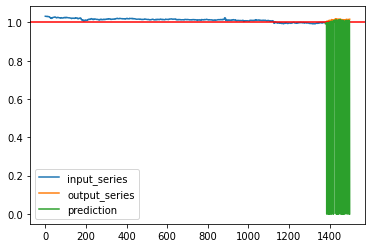

In [ ]:
idx = 300
# train data 중 sample_id 1121에 해당하는 x_series로 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# pred_dim1 = np.zeros(120)
# pred_dim1 = preds[0,,0]
# pred_dim1.shape

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), test_pred_array[idx], label = 'prediction')
plt.legend()
plt.show()

---

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [ ]:
    #학습
    x_series = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
    y_series = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
    test_x_series = np.reshape(test_x_array[idx,:,1], (1, 1380,1)) #각 open 값의 3차원형

    preds = model.predict(test_x_series)
    test_pred_array[idx,:] = preds

    model.fit(x_series, y_series, epochs = 10, batch_size = 32)

    #여기서 predict를 바로 해야 함
    preds = model.predict(test_x_series)
    test_pred_array[idx,:] = preds

Epoch 1/10
1/1 [==============================] - 1s 781ms/step - loss: 0.3014 - mse: 0.3014
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.3013 - mse: 0.3013
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3013 - mse: 0.3013
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3014 - mse: 0.3014
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3014 - mse: 0.3014
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3013 - mse: 0.3013
Epoch 7/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3014 - mse: 0.3014
Epoch 8/10
1/1 [==============================] - 0s 65ms/step - loss: 0.3014 - mse: 0.3014
Epoch 9/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3013 - mse: 0.3013
Epoch 10/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3013 - mse: 0.3013


In [ ]:
idx = 300  #529보다 작아야 함
# train data 중 sample_id 300에 해당하는 x_series로 모델과 을 학습한 후
# y_sereis를 추론
sample_x = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
sample_y = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
sample_test_x = np.reshape(test_x_array[idx,:,1], (1, 1380,1))

model.fit(sample_x, sample_y, epochs = 10, batch_size = 32)
preds = model.predict(sample_test_x)

#train_pred_array 3차원에서 2차원으로 바꾸기
sample_x_conversion = np.zeros([1, 120])
sample_x_conversion[0, :] = preds[0, :, 0]
sample_x_conversion





Epoch 1/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3081 - mse: 0.3081
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.3081 - mse: 0.3081
Epoch 3/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - mse: 0.3081
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 0.3081 - mse: 0.3081
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3081 - mse: 0.3081
Epoch 6/10
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - mse: 0.3081
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081
Epoch 9/10
1/1 [==============================] - 0s 60ms/step - loss: 0.3081 - mse: 0.3081
Epoch 10/10
1/1 [==============================] - 0s 64ms/step - loss: 0.3081 - mse: 0.3081


array([[1.00356948, 1.00306702, 1.00519633, 1.00551546, 1.00902522,
        1.00974476, 0.        , 1.00883973, 0.        , 1.01203108,
        1.0101856 , 1.01047814, 1.01020932, 0.        , 1.00863254,
        0.        , 0.        , 1.01030636, 0.        , 1.01452637,
        0.        , 1.01233077, 0.        , 1.01179194, 1.01193976,
        1.01302612, 0.        , 1.01473641, 1.0136317 , 0.        ,
        1.01622272, 1.01719332, 1.01751125, 0.        , 1.01644373,
        1.01524377, 1.0164026 , 1.01492727, 0.        , 1.01785707,
        0.        , 1.01621389, 1.01527977, 1.01646304, 1.01844096,
        1.01736283, 1.01820385, 1.02110529, 1.02205575, 1.02041376,
        1.02069306, 1.01901054, 0.        , 0.        , 0.        ,
        1.02064741, 0.        , 1.01797199, 1.02009177, 0.        ,
        1.01951885, 1.01905131, 0.        , 0.        , 1.02034199,
        1.021106  , 1.01932454, 0.        , 1.02035964, 1.02088726,
        1.01922083, 1.02033615, 1.02139759, 1.02

In [ ]:
np.arange(1380, 1380+120).shape

(120,)

In [ ]:
len(sample_x_conversion[0])

120

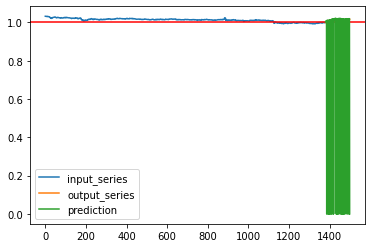

In [ ]:
x = train_x_array[idx,:,1]
y = train_y_array[idx,:,1]

plot_series(x, y)
plt.plot(np.arange(1380, 1380+120), sample_x_conversion[0], label = 'prediction')
plt.legend()
plt.show()

제대로 학습되지 않고 있다는 것을 알 수 있다.

In [ ]:
# 정확도 측정(수정필요)
# # Test RMSE 측정하기
# from sklearn.metrics import mean_squared_error, r2_score
# from math import sqrt

# rmse = sqrt(mean_squared_error(pred_y, test_y))
# print(rmse)